# Analyzing Bechdel test results using TMDB data : 
# gender of the main character on the poster

We push forward the task initiated in `4. Analyzing gender representation in posters with Computer Vision` and investigate to what extent the gender of the main character on the movie posters depend on the Bechdel ratings.

## Import packages

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%matplotlib inline

In [15]:
# For developers who want to use the latest development version or the library locally
# Use poetry to install dependencies
import sys
sys.path.append("../") # Or change to the folder to the direction of the working directory

%load_ext autoreload
%autoreload 2

import bechdelai

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import matched Bechdeltest / TMDB data from csv files
The fetching and matching steps have already been done in the tutorial `BechdelAI tutorial #3 - Analyzing Bechdel test results using TMDB data`. Here, we import data from json files created at the end of this notebook (actually in the original version of this tutorial, csv files were created but this raises some issues I cannot get rid of easily, e.g. lists are transformed to strings. That's why I switched to the json format). 

In [16]:
path = "Bechdel_TMDB_data/"       # Enter the path to the csv files
metadata = pd.read_json(path + "bechdel_movies_metadata.json")

pd.set_option('display.max_columns', None)
metadata.head(2)

adult                     backdrop_path belongs_to_collection  budget  \
0  False  /6vYffq6NoneNmNPp6IsobnnlrHS.jpg                  None       0   
1  False                              None                  None       0   

                                genres homepage      id     imdb_id  \
0  [{'id': 99, 'name': 'Documentary'}]           315946   tt3155794   
1    [{'id': 16, 'name': 'Animation'}]           766094  tt14495706   

  original_language     original_title  \
0                fr   Passage de Venus   
1                xx  La Rosace Magique   

                                            overview  popularity  \
0  Photo sequence of the rare transit of Venus ov...       4.509   
1  Praxinoscope strip of a shifting rosette. Seri...       1.011   

                        poster_path production_companies  \
0   /XWPDZzK7N2WQcejI8W96IxZEeP.jpg                   []   
1  /5zeVMAp3R4QHGarSc4Bf3B1uBY2.jpg                   []   

                       production_countries release_date  revenue  runtime  \
0  [{'iso_3166_1': 'FR', 'name': 'France'}]   1874-12-09        0        1   
1  [{'iso_3166_1': 'FR', 'name': 'France'}]   1878-05-07        0        1   

                                    spoken_languages    status tagline  \
0  [{'english_name': 'No Language', 'iso_639_1': ...  Released           
1  [{'english_name': 'No Language', 'iso_639_1': ...  Released           

               title  video  vote_average  vote_count  bechdel_rating  count  
0   Passage of Venus  False           6.2          80               0      1  
1  The Magic Rosette  False           6.0          13               0      1

Note : some movies have no poster e.g.

In [17]:
metadata[metadata['id']==60246]

adult backdrop_path belongs_to_collection  budget  \
5905  False          None                  None       0   

                                                 genres homepage     id  \
5905  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...           60246   

        imdb_id original_language original_title  \
5905  tt1326221                en      Fruit Fly   

                                               overview  popularity  \
5905  Filipina performance artist Bethesda moves int...         0.6   

     poster_path production_companies production_countries release_date  \
5905        None                   []                   []   2009-09-28   

      revenue  runtime spoken_languages    status tagline      title  video  \
5905        0       94               []  Released          Fruit Fly  False   

      vote_average  vote_count  bechdel_rating  count  
5905           4.3           6               3      1

## Basic pre-processing

Add a column for the release year

In [18]:
metadata['release_date'] = pd.to_datetime(metadata['release_date'])
metadata['release_year'] = metadata['release_date'].dt.year
metadata.head(2)

adult                     backdrop_path belongs_to_collection  budget  \
0  False  /6vYffq6NoneNmNPp6IsobnnlrHS.jpg                  None       0   
1  False                              None                  None       0   

                                genres homepage      id     imdb_id  \
0  [{'id': 99, 'name': 'Documentary'}]           315946   tt3155794   
1    [{'id': 16, 'name': 'Animation'}]           766094  tt14495706   

  original_language     original_title  \
0                fr   Passage de Venus   
1                xx  La Rosace Magique   

                                            overview  popularity  \
0  Photo sequence of the rare transit of Venus ov...       4.509   
1  Praxinoscope strip of a shifting rosette. Seri...       1.011   

                        poster_path production_companies  \
0   /XWPDZzK7N2WQcejI8W96IxZEeP.jpg                   []   
1  /5zeVMAp3R4QHGarSc4Bf3B1uBY2.jpg                   []   

                       production_countries release_date  revenue  runtime  \
0  [{'iso_3166_1': 'FR', 'name': 'France'}]   1874-12-09        0        1   
1  [{'iso_3166_1': 'FR', 'name': 'France'}]   1878-05-07        0        1   

                                    spoken_languages    status tagline  \
0  [{'english_name': 'No Language', 'iso_639_1': ...  Released           
1  [{'english_name': 'No Language', 'iso_639_1': ...  Released           

               title  video  vote_average  vote_count  bechdel_rating  count  \
0   Passage of Venus  False           6.2          80               0      1   
1  The Magic Rosette  False           6.0          13               0      1   

   release_year  
0        1874.0  
1        1878.0

Keep only relevant features

In [19]:
metadata = metadata[['genres', 'id', 'original_title', 'release_year', 'bechdel_rating']]

# Explode the graph by the list of genres and get genre name
def get_name(dic):
    if isinstance(dic, dict):
        return dic['name']
    else:
        return dic
    
metadata = metadata.explode("genres")
metadata['genres'] = metadata['genres'].apply(get_name) 



In [20]:
metadata.head()

genres      id              original_title  release_year  \
0  Documentary  315946            Passage de Venus        1874.0   
1    Animation  766094           La Rosace Magique        1878.0   
2    Animation  194079  Sallie Gardner at a Gallop        1878.0   
2  Documentary  194079  Sallie Gardner at a Gallop        1878.0   
3    Animation  751212           Le Singe Musicien        1878.0   

   bechdel_rating  
0               0  
1               0  
2               0  
2               0  
3               0

## Choose movies

Choose movies released in 2022 that are not animation movies

In [21]:
metadata_select = metadata[metadata['release_year']==2022]
animation_ids = metadata_select[metadata_select['genres']=='Animation']['id'].tolist()
metadata_select = metadata_select[-metadata_select['id'].isin(animation_ids)]
# Drop the column 'genres', we don't need it anymore
metadata_select = metadata_select.drop("genres", axis = 1)
metadata_select = metadata_select.drop_duplicates()

In [22]:
metadata_select.isna().sum(axis = 0)

id                0
original_title    0
release_year      0
bechdel_rating    0
dtype: int64

## Download all posters 

To be run only once (of course no need to re-download the posters if already done)

In [23]:
poster_folder = "posters_2022/"     # choose where to store the posters

In [24]:
from bechdelai.data.tmdb import TMDB

In [25]:
'''
movie_select_ids = metadata_select['id'].tolist()

# tmdb = TMDB(api_key = "XXXXXXX") #replace here with your API_KEY
# If you don't pass an API key, the TMDB class will look for one TMDB_API_KEY in an .env file
# So if you have a .env file configured, you can instantiate the TMDB client with the simple function
tmdb = TMDB()
tmdb.download_all_posters(movie_select_ids, poster_folder)
'''

  0%|          | 0/130 [00:00<?, ?it/s]

## Poster analysis

In [26]:
from PIL import Image

In [27]:
from bechdelai.image.face_detection import FacesDetector
from bechdelai.image.gender_detection import GenderDetector
from bechdelai.image.clip import CLIP

In [28]:
fd = FacesDetector()
gd = GenderDetector()

Loading CLIP model


In [30]:
# Function that returns all infos extracted by poster analysis
# for the posters with ids in the list movie_ids and with poster images stored in poster_folder
def posters_analysis(movie_ids, poster_folder = "posters_2022/"):
    all_probas = pd.DataFrame()
    for movie_id in tqdm(movie_ids):    # loop on movies
        # open the poster
        poster_path = poster_folder + str(movie_id) + ".png"
        poster = Image.open(poster_path) 
        # convert to RGB 
        # (Input images need to have 3 channels for get_image in retinaface/RetinaFace.py)
        if poster.mode=='L':
            poster = poster.convert('RGB')
        # detect the faces
        rois, faces = fd.detect(np.array(poster), method = "retinaface", padding = 20)
        # close the poster
        poster.close()
        # predict the genders
        try:   # if faces can be detected
            probas = gd.predict(faces)
            # complete the dataframe `probas` containing results for one movie
            probas['id'] = movie_id
            probas['rois'] = pd.Series([{'face_'+str(idx+1): rois['face_'+str(idx+1)]} for idx in probas.index.tolist()])
        except:  #if faces cannot be detected
            column_names = ['man', 'woman', 'diff', 'gender', 'area', 'area_percentage_relative', 'id', 'rois']
            probas = pd.DataFrame(columns = column_names, index=[0])   # empty dataframe
            probas['id'] = movie_id
            probas['gender'] = 'no face'
        # update the dataframe `all_probas` containing results for all movies
        all_probas = pd.concat([all_probas, probas], axis = 0)
       
        
    return all_probas


# Function that adds to the input dataframe containing only metadata infos
# some columns containing the gender of the MAIN character on the movie poster (and other poster analysis infos) 
def add_poster_analysis(dataframe, poster_folder = "posters_2022/"):
    # Get movie ids
    movie_ids = dataframe['id'].tolist()
    # Perform the complete poster analysis
    all_probas_df = posters_analysis(movie_ids, poster_folder = poster_folder)
    #Merge results with the dataframe
    dataframe = dataframe.merge(all_probas_df, on = "id", how = 'left')
    # For each movie, keep only infos about the main character on the poster 
    # (i.e the character with the largest face area)
    dataframe = (dataframe
                 .sort_values(by = ['id', 'area'], ascending = False)
                 .groupby('id')
                 .head(1)
                )
    
    return all_probas_df, dataframe



#### Optional : show all infos extracted from poster analysis on a few posters
Note that the movie with id=788921 has no detected faces

In [31]:
# Run poster analysis
movie_ids = [579974, 619730, 788921]
all_probas = posters_analysis(movie_ids)

# Show 
pd.set_option('display.max_columns', None)
display(all_probas)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.89s/it]


man     woman      diff   gender    area  area_percentage_relative  \
0  0.963363  0.036637  0.926725      man  317504                  0.334274   
1  0.976153  0.023847  0.952306      man  260631                  0.274397   
2  0.070068  0.929932  0.859864    woman   98736                  0.103951   
3  0.990794  0.009206  0.981588      man   69768                  0.073453   
4  0.916439  0.083561  0.832878      man  139536                  0.146906   
5  0.994355  0.005645  0.988709      man   63656                  0.067018   
0  0.203073  0.796927  0.593853    woman   18788                  1.000000   
0       NaN       NaN       NaN  no face     NaN                       NaN   

       id                                               rois  
0  579974  {'face_1': {'score': 0.999738872051239, 'facia...  
1  579974  {'face_2': {'score': 0.9993860721588135, 'faci...  
2  579974  {'face_3': {'score': 0.9993718266487122, 'faci...  
3  579974  {'face_4': {'score': 0.9980438947677612, 'faci...  
4  579974  {'face_5': {'score': 0.9978998899459839, 'faci...  
5  579974  {'face_6': {'score': 0.9935625791549683, 'faci...  
0  619730  {'face_1': {'score': 0.9801728129386902, 'faci...  
0  788921                                                NaN

#### Run poster analysis for all selected movies

In [32]:
_, metadata_select = add_poster_analysis(metadata_select, poster_folder = poster_folder)

 18%|██████████████▎                                                                  | 23/130 [01:06<05:08,  2.89s/it]


KeyboardInterrupt: 

Save results

In [18]:
metadata_select.to_pickle("metadata_select_2022_noanim.pkl")

## Show posters

Load results

In [86]:
metadata_select = pd.read_pickle("metadata_select_2022_noanim.pkl")

In [87]:
metadata_select.isna().sum(axis = 0)

id                           0
original_title               0
release_year                 0
bechdel_rating               0
man                         21
woman                       21
diff                        21
gender                       0
area                        21
area_percentage_relative    21
rois                        21
dtype: int64

Movies for which no faces has been detected on the poster

In [88]:
metadata_select[metadata_select.isna().any(axis = 1)]

id                original_title  release_year  bechdel_rating  man  \
328  928344  Weird: The Al Yankovic Story        2022.0               1  NaN   
247  852046                        Athena        2022.0               2  NaN   
246  848685                     As bestas        2022.0               3  NaN   
358  843932                         Nanny        2022.0               3  NaN   
199  838330                      Not Okay        2022.0               3  NaN   
243  830788                The Invitation        2022.0               3  NaN   
172  819309                     Emergency        2022.0               3  NaN   
273  817758                           TÁR        2022.0               3  NaN   
322  791333            El cuarto pasajero        2022.0               0  NaN   
6    788921        Everything Will Change        2022.0               0  NaN   
125  780609                           Men        2022.0               3  NaN   
189  766507                          Prey        2022.0               3  NaN   
194  762504                          Nope        2022.0               1  NaN   
155  760104                             X        2022.0               3  NaN   
378  736732                           브로커        2022.0               3  NaN   
195  698948                Thirteen Lives        2022.0               0  NaN   
53   632727       Texas Chainsaw Massacre        2022.0               3  NaN   
209  630720                 Occhiali neri        2022.0               3  NaN   
9    614939                          Bros        2022.0               3  NaN   
196  520023          Bodies Bodies Bodies        2022.0               3  NaN   
242  301502                        Blonde        2022.0               2  NaN   

     woman  diff   gender area  area_percentage_relative rois  
328    NaN   NaN  no face  NaN                       NaN  NaN  
247    NaN   NaN  no face  NaN                       NaN  NaN  
246    NaN   NaN  no face  NaN                       NaN  NaN  
358    NaN   NaN  no face  NaN                       NaN  NaN  
199    NaN   NaN  no face  NaN                       NaN  NaN  
243    NaN   NaN  no face  NaN                       NaN  NaN  
172    NaN   NaN  no face  NaN                       NaN  NaN  
273    NaN   NaN  no face  NaN                       NaN  NaN  
322    NaN   NaN  no face  NaN                       NaN  NaN  
6      NaN   NaN  no face  NaN                       NaN  NaN  
125    NaN   NaN  no face  NaN                       NaN  NaN  
189    NaN   NaN  no face  NaN                       NaN  NaN  
194    NaN   NaN  no face  NaN                       NaN  NaN  
155    NaN   NaN  no face  NaN                       NaN  NaN  
378    NaN   NaN  no face  NaN                       NaN  NaN  
195    NaN   NaN  no face  NaN                       NaN  NaN  
53     NaN   NaN  no face  NaN                       NaN  NaN  
209    NaN   NaN  no face  NaN                       NaN  NaN  
9      NaN   NaN  no face  NaN                       NaN  NaN  
196    NaN   NaN  no face  NaN                       NaN  NaN  
242    NaN   NaN  no face  NaN                       NaN  NaN

In [36]:
from bechdelai.image.utils import show_faces_on_image, show_all_faces

In [81]:
# Function that displays all posters of movies in res_df
# and shows frames around faces if faces are detected
# This is slow ...
def show_posters_with_main_face(res_df, 
                                poster_folder = "posters_2022/", 
                                figsize = [12, 10],     # Size of the figure [width, height]
                                n_cols = 6,         # Number of columns in the plot
                                wspace = 0.05,  # amount of width reserved for space between subplots (in %)
                                hspace = 0.2,    # amount of height reserved for space between subplots (in %),
                                title = 'rating',   # title category
                                fontsize = 8      # fontsize for titles
                               ):
     # Get the list of movie ids
    movie_ids = res_df['id'].tolist()
    
    # Initialize the figure
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(len(movie_ids)//n_cols+1, n_cols, wspace=wspace, hspace=hspace, figure=fig)
    row_val = 0        # Index to count rows in the plot
    
    # Loop on movies
    for idx, movie_id in enumerate(movie_ids):    
        # open the poster
        poster_path = poster_folder + str(movie_id) + ".png"
        poster = Image.open(poster_path) 
        
        # Get relevant infos
        rois, gender, bechdel_rating, year = res_df[res_df['id']==movie_id][['rois', 'gender', 'bechdel_rating', 'release_year']].values[0]
        
        # Show the poster with the main face and the bechdel rating
        try:      # if faces have been detected on the poster
            img_with_faces = show_faces_on_image(poster, rois, width = 10, genders = [gender])
            #face_colors = {'man': (0, 0, 255), 'woman': (255,192,203)}
            #img_with_faces = show_faces_on_image(poster, rois, width = 10, color = face_colors[gender]) 
            #img_with_faces = img_with_faces.resize((100,150))
        except:
            img_with_faces = poster
        
        ax = fig.add_subplot(gs[row_val, idx%n_cols])
        ax.imshow(img_with_faces)
        if title=='rating':
            ax.set_title("Bechdel rating = "+str(bechdel_rating), fontsize = fontsize)
        elif title=='year':
            ax.set_title("Release year = "+str(int(year)), fontsize = fontsize)
        elif title=='none':
            pass
        else:
            raise ValueError("Unknown title category")
        ax.set_axis_off()
        if (idx+1)%n_cols==0: 
            row_val = row_val + 1 


Show posters on which no face has been detected

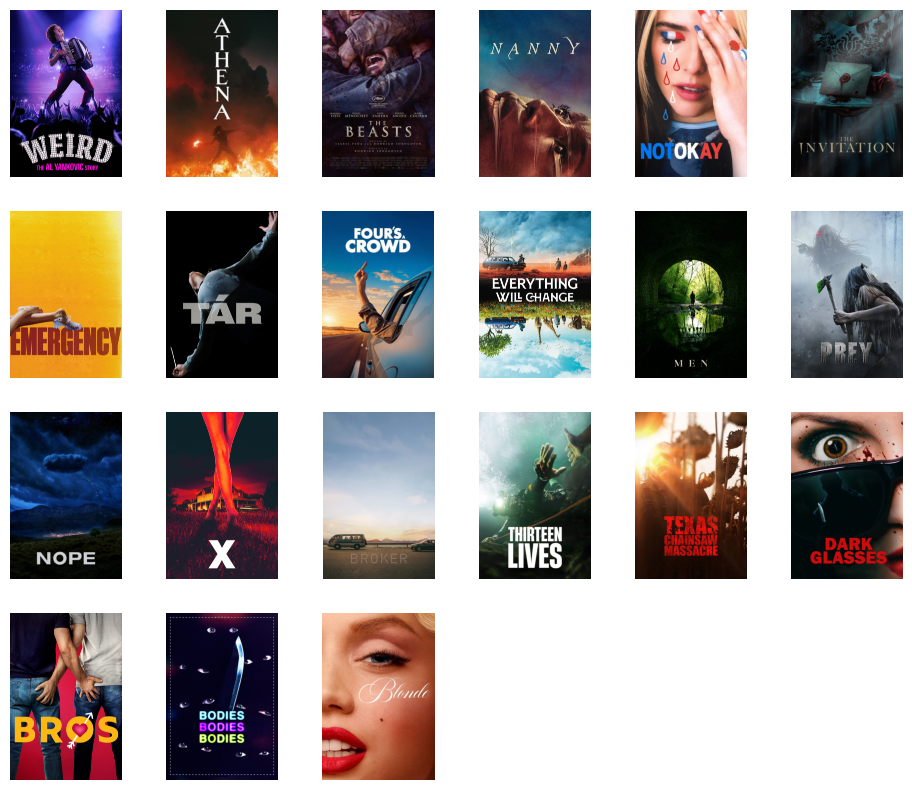

In [109]:
show_posters_with_main_face(metadata_select[metadata_select.isna().any(axis = 1)], title = 'none')

Show posters with unknown gender

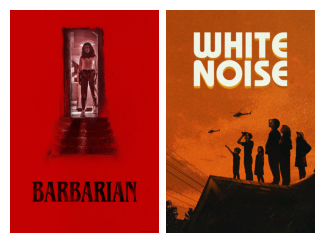

In [111]:
show_posters_with_main_face(metadata_select[metadata_select['gender']=='unknown'], title='none')

Show all posters

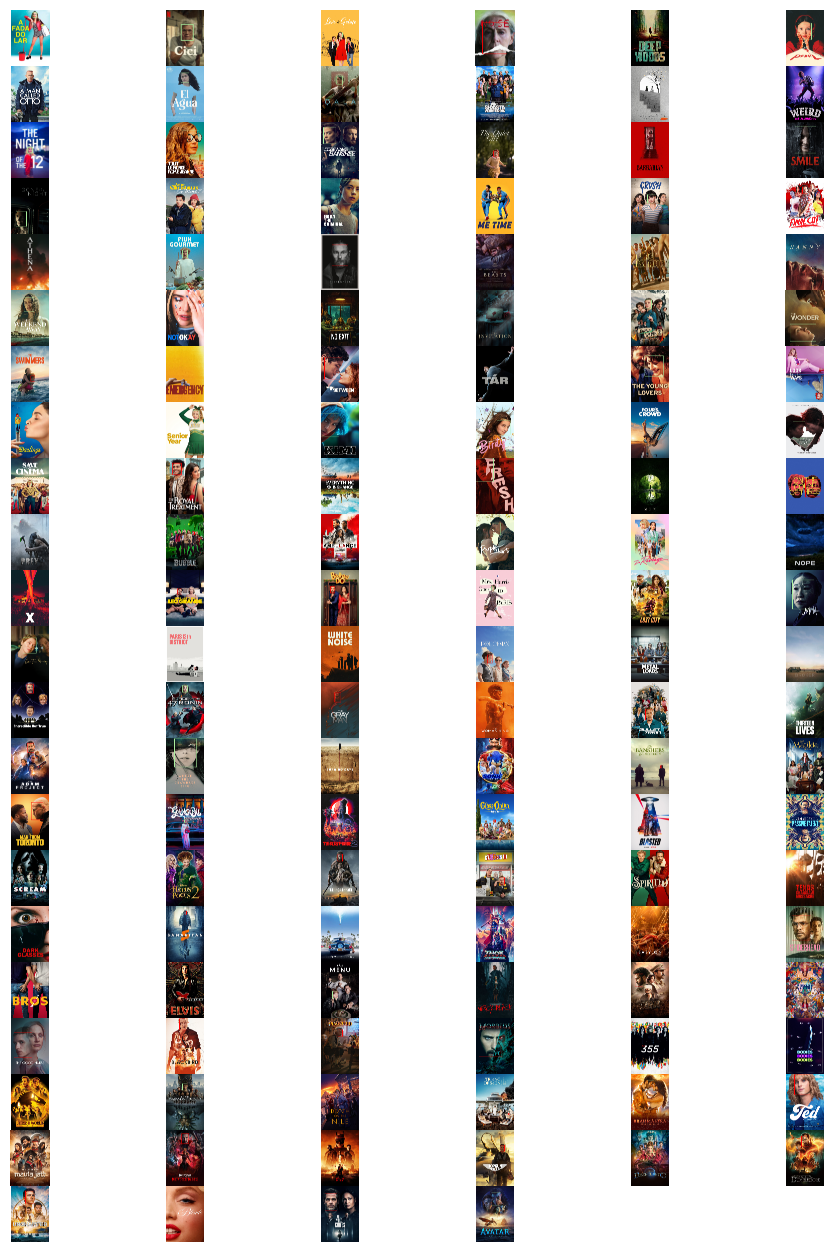

In [84]:
#show_posters_with_main_face(metadata_select, figsize = [24, 30], n_cols = 10, wspace = 0.002, hspace = 0.3)
show_posters_with_main_face(metadata_select, figsize = [12, 16], n_cols = 6, wspace = 0, hspace = 0, title='none')

Study gender repartition

In [60]:
data = metadata_select[['id', 'gender']]
data = data.groupby('gender').count().reset_index()

fig = px.pie(
    data,
    values = "id",
    names = "gender",
    color_discrete_sequence = px.colors.qualitative.Pastel,  #[px.colors.qualitative.Pastel[i] for i in [5, 6]]
    category_orders = {"gender": ['man', 'woman', 'unknown', 'no face']},
    labels = {"gender": "Gender of the main character"},
    height = 400,
)

# center the title
fig.update_layout(title_text='Gender of the main character on 130 posters<br>'
                  +'of (no animation) movies released in 2022<br>',
                  #+'(source: bechdeltest.com & IMDB)', 
                  title_x=0.5,
                  title_y=0.95,
                  title_xanchor = 'center',
                  title_yanchor = 'top'
                 )       

fig.show()

Same with other graphical chart

In [70]:
palette_1 = [
    "#ffb46a",
    "#f8ed78",
    "#acef9f",
    "#65e986",
    "#69efc2",
]

palette_2 = [
    "#b094df",  # Man
    "#99dc8d",  # Woman
]

palette_3 = [
    "#b094df",  # Man
    "#b5f0ff", # Non binary
    "#99dc8d",  # Woman
]

palette_4 = [
    "#b094df",  # Man
    "#99dc8d",  # Woman
    "#b5f0ff", # Unknown
    "#ffb46a",   # no face
]

In [71]:
data = metadata_select[['id', 'gender']]
data = data.groupby('gender').count().reset_index()

fig = px.pie(
    data,
    values = "id",
    names = "gender",
    color_discrete_sequence = palette_4,
    category_orders = {"gender": ['man', 'woman', 'unknown', 'no face']},
    labels = {"gender": "Gender of the main character"},
    height = 400,
)

# center the title
fig.update_layout(title_text='Gender of the main character on 130 posters<br>'
                  +'of (no animation) movies released in 2022<br>',
                  #+'(source: bechdeltest.com & IMDB)', 
                  title_x=0.5,
                  title_y=0.95,
                  title_xanchor = 'center',
                  title_yanchor = 'top',
                  font=dict(family="Poppins, sans-serif", size=15),
                  plot_bgcolor="rgba(0, 0, 0, 0)",
                  xaxis=dict(showgrid=True),
                  yaxis=dict(showgrid=True),
                 )   



fig.show()

# This requires to install kaleido (that is not in the default bechdelai poetry environment)
path = "bechdeltest_tmdb_analysis_figs/poster_analysis/"
fig.write_image(path + "poster_analysis_pie_2022.svg", width = 600, height = 400)

## Study correlations between the Bechdel rating and the gender of the main character on the poster

In [72]:
metadata_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 267 to 341
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        130 non-null    int64  
 1   original_title            130 non-null    object 
 2   release_year              130 non-null    float64
 3   bechdel_rating            130 non-null    int64  
 4   man                       109 non-null    float32
 5   woman                     109 non-null    float32
 6   diff                      109 non-null    float32
 7   gender                    130 non-null    object 
 8   area                      109 non-null    object 
 9   area_percentage_relative  109 non-null    float64
 10  rois                      109 non-null    object 
dtypes: float32(3), float64(2), int64(2), object(4)
memory usage: 10.7+ KB


In [118]:
data = metadata_select[['bechdel_rating', 'gender']]

# Confusion matrix
cm = pd.crosstab(data['gender'], 
                 data['bechdel_rating'],
                 normalize = 'columns',
                 #normalize = False,
                 colnames = ['Bechdel rating'],
                 rownames = ["Main character's gender"],
                 margins = True)

# Re-order the lines in the confusion matrix
cm = cm.reindex(['man', 'woman', 'unknown', 'no face'], axis=0)

# Customize table style
def make_pretty(styler):
    styler.set_caption("Poster analysis of 130 (no animation) movies from bechdeltest.com released in 2022")
    styler.format('{:,.1%}'.format)
    styler.background_gradient(axis=0, vmin=0, vmax=1, cmap="Reds")
    styler.set_properties(**{'width': '80px'})
    return styler



cm.style.pipe(make_pretty)

In [74]:
data = metadata_select[['bechdel_rating', 'gender']]
data['bechdel_rating'] = data['bechdel_rating'].astype('string')

px.histogram(
    data,
    x = "bechdel_rating",
    color = "gender",
    color_discrete_sequence = px.colors.qualitative.Pastel,  #[px.colors.qualitative.Pastel[i] for i in [5, 6]]
    category_orders = {"gender": ['man', 'woman', 'unknown', 'no face'],
                       "bechdel_rating": [0, 1, 2, 3]
                      },
    labels = {"bechdel_rating": "Bechdel rating",
              "gender": "Gender of the main character"
             },
    title = 'Poster analysis of 130 (no animation) movies from bechdeltest.com released in 2022',
    height = 400,
).show()

Same with another graphical chart

In [80]:
data = metadata_select[['bechdel_rating', 'gender']]
data['bechdel_rating'] = data['bechdel_rating'].astype('string')

fig = px.histogram(
    data,
    x = "bechdel_rating",
    color = "gender",
    color_discrete_sequence = palette_4,
    category_orders = {"gender": ['man', 'woman', 'unknown', 'no face'],
                       "bechdel_rating": [0, 1, 2, 3]
                      },
    labels = {"bechdel_rating": "Bechdel rating",
              "gender": "Gender of the main character"
             },
    title = 'Poster analysis of 130 (no animation) movies from bechdeltest.com released in 2022',
    height = 400,
)


fig.update_layout(font=dict(family="Poppins, sans-serif",
                                size=15),
                      plot_bgcolor="rgba(0, 0, 0, 0)",
                      xaxis=dict(showgrid=True),
                      yaxis=dict(showgrid=True),
                     )

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', tickangle = 0)
fig.update_yaxes(showline=False, gridcolor='LightGray')

fig.show()

# This requires to install kaleido (that is not in the default bechdelai poetry environment)
path = "bechdeltest_tmdb_analysis_figs/poster_analysis/"
fig.write_image(path + "poster_analysis_histo_2022.svg", width = 700, height = 300)

# Repeat for movies between 1960 and 2022 and study evolution over years

Look at the distribution of movies over years

In [44]:
px.histogram(
    metadata,
    x = "release_year",
    height = 300
).show()

### Choose movies : keep 5% of (no animation) movies per year, between 1960 and 2022

In [45]:
seed = 123        # seed for the random selection of movies per year
movie_per_year_frac = 0.05           # fraction of movies to keep per year

In [46]:
# Select movies between 1960 and 2022
metadata_select2 = metadata[(metadata['release_year']<=2022) & (metadata['release_year']>=1960)]
# Remove animation movies
animation_ids = metadata_select2[metadata_select2['genres']=='Animation']['id'].tolist()
metadata_select2 = metadata_select2[-metadata_select2['id'].isin(animation_ids)]
# Keep only a fraction of movies per year
metadata_select2 = metadata_select2.groupby("release_year").sample(frac = movie_per_year_frac, random_state = seed)
# Drop the column 'genres', we don't need it anymore
metadata_select2 = metadata_select2.drop("genres", axis = 1)
metadata_select2 = metadata_select2.drop_duplicates()

In [47]:
px.histogram(
    metadata_select2,
    x = "release_year",
    nbins = 63,
    height = 300
).show()

In [48]:
print("Number of movies = ", metadata_select2.shape[0])

Number of movies =  928


In [49]:
metadata_select2.isna().sum(axis = 0)

id                0
original_title    0
release_year      0
bechdel_rating    0
dtype: int64

### Download all posters

In [52]:
poster_folder2 = "posters_1960to2022_5perc/"     # choose where to store the posters

In [15]:
'''
movie_select_ids2 = metadata_select2['id'].tolist()

tmdb = TMDB()
tmdb.download_all_posters(movie_select_ids2, poster_folder2)
'''

"\nmovie_select_ids2 = metadata_select2['id'].tolist()\n\ntmdb = TMDB()\ntmdb.download_all_posters(movie_select_ids2, poster_folder2)\n"

### Poster analysis

Remove movies whose posters could not be downloaded

In [16]:
ids_to_remove = [60246, 1063142, 64932, 204397]
metadata_select2 = metadata_select2[-metadata_select2['id'].isin(ids_to_remove)]
print("Number of movies = ", metadata_select2.shape[0])

Number of movies =  924


Some images don't have 3 channels

In [34]:
movie_id = 16672
poster_path = poster_folder2 + str(movie_id) + ".png"
poster = Image.open(poster_path)
print(poster.mode)
poster.show()
poster = poster.convert("RGB")
poster.show()

L


Run poster analysis

In [36]:
_, metadata_select2 = add_poster_analysis(metadata_select2, poster_folder = poster_folder2)

  0%|                                                                                          | 0/924 [00:00<?, ?it/s]

2134


  0%|                                                                                  | 1/924 [00:02<38:14,  2.49s/it]

36741


  0%|▏                                                                                 | 2/924 [00:04<37:04,  2.41s/it]

31392


  0%|▎                                                                                 | 3/924 [00:07<36:49,  2.40s/it]

11167


  0%|▎                                                                                 | 4/924 [00:09<35:53,  2.34s/it]

18642


  1%|▍                                                                                 | 5/924 [00:11<36:46,  2.40s/it]

171898


  1%|▌                                                                                 | 6/924 [00:14<36:38,  2.39s/it]

65009


  1%|▌                                                                                 | 7/924 [00:16<36:03,  2.36s/it]

990


  1%|▋                                                                                 | 8/924 [00:19<36:08,  2.37s/it]

238378


  1%|▊                                                                                 | 9/924 [00:21<36:16,  2.38s/it]

499


  1%|▉                                                                                | 10/924 [00:23<36:09,  2.37s/it]

802


  1%|▉                                                                                | 11/924 [00:26<35:40,  2.34s/it]

33468


  1%|█                                                                                | 12/924 [00:28<36:26,  2.40s/it]

595


  1%|█▏                                                                               | 13/924 [00:31<39:09,  2.58s/it]

42987


  2%|█▏                                                                               | 14/924 [00:34<38:25,  2.53s/it]

2690


  2%|█▎                                                                               | 15/924 [00:36<38:53,  2.57s/it]

86764


  2%|█▍                                                                               | 16/924 [00:38<37:25,  2.47s/it]

5925


  2%|█▍                                                                               | 17/924 [00:41<37:06,  2.45s/it]

16672


  2%|█▌                                                                               | 18/924 [00:43<37:04,  2.46s/it]

8073


  2%|█▋                                                                               | 19/924 [00:46<37:10,  2.47s/it]

39231


  2%|█▊                                                                               | 20/924 [00:48<38:11,  2.53s/it]

1682


  2%|█▊                                                                               | 21/924 [00:51<38:44,  2.57s/it]

44736


  2%|█▉                                                                               | 22/924 [00:53<37:38,  2.50s/it]

20723


  2%|██                                                                               | 23/924 [00:56<37:21,  2.49s/it]

19199


  3%|██                                                                               | 24/924 [00:58<37:00,  2.47s/it]

11481


  3%|██▏                                                                              | 25/924 [01:01<38:09,  2.55s/it]

28719


  3%|██▎                                                                              | 26/924 [01:03<37:28,  2.50s/it]

45706


  3%|██▎                                                                              | 27/924 [01:06<37:36,  2.52s/it]

38606


  3%|██▍                                                                              | 28/924 [01:09<38:03,  2.55s/it]

42719


  3%|██▌                                                                              | 29/924 [01:11<37:48,  2.53s/it]

17295


  3%|██▋                                                                              | 30/924 [01:15<43:12,  2.90s/it]

37247


  3%|██▋                                                                              | 31/924 [01:17<41:24,  2.78s/it]

61943


  3%|██▊                                                                              | 32/924 [01:20<40:44,  2.74s/it]

32489


  4%|██▉                                                                              | 33/924 [01:23<39:58,  2.69s/it]

5767


  4%|██▉                                                                              | 34/924 [01:25<40:10,  2.71s/it]

105584


  4%|███                                                                              | 35/924 [01:28<38:53,  2.62s/it]

41861


  4%|███▏                                                                             | 36/924 [01:30<38:40,  2.61s/it]

34131


  4%|███▏                                                                             | 37/924 [01:33<38:51,  2.63s/it]

335


  4%|███▎                                                                             | 38/924 [01:36<38:35,  2.61s/it]

4191


  4%|███▍                                                                             | 39/924 [01:38<37:55,  2.57s/it]

72309


  4%|███▌                                                                             | 40/924 [01:41<38:20,  2.60s/it]

133343


  4%|███▌                                                                             | 41/924 [01:43<37:09,  2.53s/it]

14030


  5%|███▋                                                                             | 42/924 [01:46<36:52,  2.51s/it]

20391


  5%|███▊                                                                             | 43/924 [01:48<36:53,  2.51s/it]

11657


  5%|███▊                                                                             | 44/924 [01:51<36:11,  2.47s/it]

71943


  5%|███▉                                                                             | 45/924 [01:53<38:06,  2.60s/it]

59408


  5%|████                                                                             | 46/924 [01:56<38:45,  2.65s/it]

26451


  5%|████                                                                             | 47/924 [01:58<37:05,  2.54s/it]

72899


  5%|████▏                                                                            | 48/924 [02:01<37:16,  2.55s/it]

48207


  5%|████▎                                                                            | 49/924 [02:03<36:17,  2.49s/it]

16154


  5%|████▍                                                                            | 50/924 [02:06<36:22,  2.50s/it]

39261


  6%|████▍                                                                            | 51/924 [02:09<36:49,  2.53s/it]

636


  6%|████▌                                                                            | 52/924 [02:11<36:08,  2.49s/it]

2000


  6%|████▋                                                                            | 53/924 [02:14<36:45,  2.53s/it]

22910


  6%|████▋                                                                            | 54/924 [02:17<39:41,  2.74s/it]

62382


  6%|████▊                                                                            | 55/924 [02:19<38:53,  2.69s/it]

1721


  6%|████▉                                                                            | 56/924 [02:22<38:58,  2.69s/it]

10238


  6%|████▉                                                                            | 57/924 [02:24<37:38,  2.60s/it]

35669


  6%|█████                                                                            | 58/924 [02:27<36:37,  2.54s/it]

16180


  6%|█████▏                                                                           | 59/924 [02:29<35:08,  2.44s/it]

9277


  6%|█████▎                                                                           | 60/924 [02:31<34:42,  2.41s/it]

28797


  7%|█████▎                                                                           | 61/924 [02:34<34:44,  2.42s/it]

8327


  7%|█████▍                                                                           | 62/924 [02:36<35:21,  2.46s/it]

26196


  7%|█████▌                                                                           | 63/924 [02:39<35:07,  2.45s/it]

14267


  7%|█████▌                                                                           | 64/924 [02:41<35:10,  2.45s/it]

592


  7%|█████▋                                                                           | 65/924 [02:43<34:08,  2.38s/it]

22048


  7%|█████▊                                                                           | 66/924 [02:46<35:49,  2.51s/it]

22121


  7%|█████▊                                                                           | 67/924 [02:49<35:08,  2.46s/it]

24402


  7%|█████▉                                                                           | 68/924 [02:51<33:53,  2.38s/it]

2139


  7%|██████                                                                           | 69/924 [02:53<34:13,  2.40s/it]

762


  8%|██████▏                                                                          | 70/924 [02:56<33:54,  2.38s/it]

12223


  8%|██████▏                                                                          | 71/924 [02:58<33:46,  2.38s/it]

3121


  8%|██████▎                                                                          | 72/924 [03:04<50:47,  3.58s/it]

1396


  8%|██████▍                                                                          | 73/924 [03:07<48:03,  3.39s/it]

116982


  8%|██████▍                                                                          | 74/924 [03:10<43:23,  3.06s/it]

16084


  8%|██████▌                                                                          | 75/924 [03:12<41:55,  2.96s/it]

6037


  8%|██████▋                                                                          | 76/924 [03:15<41:49,  2.96s/it]

8446


  8%|██████▊                                                                          | 77/924 [03:18<42:26,  3.01s/it]

86194


  8%|██████▊                                                                          | 78/924 [03:21<40:24,  2.87s/it]

25623


  9%|██████▉                                                                          | 79/924 [03:23<38:01,  2.70s/it]

14336


  9%|███████                                                                          | 80/924 [03:26<37:29,  2.66s/it]

12707


  9%|███████                                                                          | 81/924 [03:28<36:56,  2.63s/it]

31139


  9%|███████▏                                                                         | 82/924 [03:31<37:28,  2.67s/it]

11009


  9%|███████▎                                                                         | 83/924 [03:34<37:06,  2.65s/it]

31428


  9%|███████▎                                                                         | 84/924 [03:36<35:59,  2.57s/it]

2153


  9%|███████▍                                                                         | 85/924 [03:39<36:04,  2.58s/it]

16241


  9%|███████▌                                                                         | 86/924 [03:41<34:25,  2.46s/it]

111469


  9%|███████▋                                                                         | 87/924 [03:43<33:52,  2.43s/it]

62847


 10%|███████▋                                                                         | 88/924 [03:46<33:52,  2.43s/it]

24750


 10%|███████▊                                                                         | 89/924 [03:48<32:53,  2.36s/it]

19827


 10%|███████▉                                                                         | 90/924 [03:50<33:03,  2.38s/it]

14035


 10%|███████▉                                                                         | 91/924 [03:53<34:17,  2.47s/it]

16323


 10%|████████                                                                         | 92/924 [03:55<33:21,  2.41s/it]

38438


 10%|████████▏                                                                        | 93/924 [03:58<33:28,  2.42s/it]

2768


 10%|████████▏                                                                        | 94/924 [04:00<33:20,  2.41s/it]

40034


 10%|████████▎                                                                        | 95/924 [04:02<32:50,  2.38s/it]

16769


 10%|████████▍                                                                        | 96/924 [04:05<32:32,  2.36s/it]

10765


 10%|████████▌                                                                        | 97/924 [04:07<32:54,  2.39s/it]

14460


 11%|████████▌                                                                        | 98/924 [04:10<34:21,  2.50s/it]

10323


 11%|████████▋                                                                        | 99/924 [04:12<34:08,  2.48s/it]

12528


 11%|████████▋                                                                       | 100/924 [04:15<32:53,  2.40s/it]

14900


 11%|████████▋                                                                       | 101/924 [04:17<32:59,  2.41s/it]

17450


 11%|████████▊                                                                       | 102/924 [04:20<33:44,  2.46s/it]

19429


 11%|████████▉                                                                       | 103/924 [04:22<32:59,  2.41s/it]

85


 11%|█████████                                                                       | 104/924 [04:25<34:56,  2.56s/it]

21484


 11%|█████████                                                                       | 105/924 [04:27<33:37,  2.46s/it]

9387


 11%|█████████▏                                                                      | 106/924 [04:29<32:46,  2.40s/it]

154


 12%|█████████▎                                                                      | 107/924 [04:32<33:56,  2.49s/it]

4193


 12%|█████████▎                                                                      | 108/924 [04:35<35:25,  2.60s/it]

17590


 12%|█████████▍                                                                      | 109/924 [04:37<34:51,  2.57s/it]

17692


 12%|█████████▌                                                                      | 110/924 [04:40<33:57,  2.50s/it]

26452


 12%|█████████▌                                                                      | 111/924 [04:42<34:45,  2.57s/it]

1892


 12%|█████████▋                                                                      | 112/924 [04:45<34:34,  2.55s/it]

10489


 12%|█████████▊                                                                      | 113/924 [04:48<36:26,  2.70s/it]

2455


 12%|█████████▊                                                                      | 114/924 [04:50<35:05,  2.60s/it]

9663


 12%|█████████▉                                                                      | 115/924 [04:53<34:12,  2.54s/it]

40978


 13%|██████████                                                                      | 116/924 [04:55<33:16,  2.47s/it]

57565


 13%|██████████▏                                                                     | 117/924 [04:57<33:13,  2.47s/it]

52109


 13%|██████████▏                                                                     | 118/924 [05:00<32:46,  2.44s/it]

11899


 13%|██████████▎                                                                     | 119/924 [05:02<32:37,  2.43s/it]

927


 13%|██████████▍                                                                     | 120/924 [05:05<32:16,  2.41s/it]

15144


 13%|██████████▍                                                                     | 121/924 [05:07<31:43,  2.37s/it]

37296


 13%|██████████▌                                                                     | 122/924 [05:10<33:33,  2.51s/it]

13155


 13%|██████████▋                                                                     | 123/924 [05:12<32:56,  2.47s/it]

11830


 13%|██████████▋                                                                     | 124/924 [05:14<32:21,  2.43s/it]

10176


 14%|██████████▊                                                                     | 125/924 [05:17<31:33,  2.37s/it]

67342


 14%|██████████▉                                                                     | 126/924 [05:19<31:47,  2.39s/it]

9749


 14%|██████████▉                                                                     | 127/924 [05:22<32:24,  2.44s/it]

29903


 14%|███████████                                                                     | 128/924 [05:24<33:22,  2.52s/it]

10849


 14%|███████████▏                                                                    | 129/924 [05:27<33:27,  2.53s/it]

10853


 14%|███████████▎                                                                    | 130/924 [05:29<32:52,  2.48s/it]

28941


 14%|███████████▎                                                                    | 131/924 [05:31<31:43,  2.40s/it]

51881


 14%|███████████▍                                                                    | 132/924 [05:34<31:31,  2.39s/it]

9874


 14%|███████████▌                                                                    | 133/924 [05:36<31:06,  2.36s/it]

744


 15%|███████████▌                                                                    | 134/924 [05:39<31:41,  2.41s/it]

13853


 15%|███████████▋                                                                    | 135/924 [05:41<31:02,  2.36s/it]

793


 15%|███████████▊                                                                    | 136/924 [05:43<31:24,  2.39s/it]

63269


 15%|███████████▊                                                                    | 137/924 [05:46<30:30,  2.33s/it]

279984


 15%|███████████▉                                                                    | 138/924 [05:48<30:35,  2.34s/it]

19345


 15%|████████████                                                                    | 139/924 [05:50<31:21,  2.40s/it]

12154


 15%|████████████                                                                    | 140/924 [05:56<42:32,  3.26s/it]

11896


 15%|████████████▏                                                                   | 141/924 [05:59<43:28,  3.33s/it]

11215


 15%|████████████▎                                                                   | 142/924 [06:02<40:51,  3.13s/it]

12626


 15%|████████████▍                                                                   | 143/924 [06:05<39:31,  3.04s/it]

42015


 16%|████████████▍                                                                   | 144/924 [06:08<39:02,  3.00s/it]

29445


 16%|████████████▌                                                                   | 145/924 [06:11<41:24,  3.19s/it]

14367


 16%|████████████▋                                                                   | 146/924 [06:14<40:04,  3.09s/it]

10128


 16%|████████████▋                                                                   | 147/924 [06:17<39:15,  3.03s/it]

49365


 16%|████████████▊                                                                   | 148/924 [06:20<38:27,  2.97s/it]

847


 16%|████████████▉                                                                   | 149/924 [06:23<38:06,  2.95s/it]

31052


 16%|████████████▉                                                                   | 150/924 [06:25<36:57,  2.87s/it]

107420


 16%|█████████████                                                                   | 151/924 [06:28<36:22,  2.82s/it]

2321


 16%|█████████████▏                                                                  | 152/924 [06:31<36:04,  2.80s/it]

2280


 17%|█████████████▏                                                                  | 153/924 [06:33<35:02,  2.73s/it]

5680


 17%|█████████████▎                                                                  | 154/924 [06:36<35:41,  2.78s/it]

2604


 17%|█████████████▍                                                                  | 155/924 [06:39<34:58,  2.73s/it]

2640


 17%|█████████████▌                                                                  | 156/924 [06:42<34:46,  2.72s/it]

2323


 17%|█████████████▌                                                                  | 157/924 [06:44<34:30,  2.70s/it]

10835


 17%|█████████████▋                                                                  | 158/924 [06:47<35:10,  2.76s/it]

14372


 17%|█████████████▊                                                                  | 159/924 [06:50<34:21,  2.70s/it]

709


 17%|█████████████▊                                                                  | 160/924 [06:53<36:04,  2.83s/it]

10222


 17%|█████████████▉                                                                  | 161/924 [06:56<37:05,  2.92s/it]

165


 18%|██████████████                                                                  | 162/924 [06:59<36:24,  2.87s/it]

8491


 18%|██████████████                                                                  | 163/924 [07:01<35:54,  2.83s/it]

162


 18%|██████████████▏                                                                 | 164/924 [07:04<34:59,  2.76s/it]

11856


 18%|██████████████▎                                                                 | 165/924 [07:07<34:30,  2.73s/it]

8592


 18%|██████████████▎                                                                 | 166/924 [07:09<33:47,  2.67s/it]

1498


 18%|██████████████▍                                                                 | 167/924 [07:12<33:11,  2.63s/it]

11092


 18%|██████████████▌                                                                 | 168/924 [07:14<33:03,  2.62s/it]

10166


 18%|██████████████▋                                                                 | 169/924 [07:17<32:56,  2.62s/it]

47329


 18%|██████████████▋                                                                 | 170/924 [07:20<32:24,  2.58s/it]

9586


 19%|██████████████▊                                                                 | 171/924 [07:22<32:24,  2.58s/it]

951


 19%|██████████████▉                                                                 | 172/924 [07:25<32:13,  2.57s/it]

2291


 19%|██████████████▉                                                                 | 173/924 [07:27<31:12,  2.49s/it]

11187


 19%|███████████████                                                                 | 174/924 [07:29<30:35,  2.45s/it]

174


 19%|███████████████▏                                                                | 175/924 [07:32<31:00,  2.48s/it]

59058


 19%|███████████████▏                                                                | 176/924 [07:34<30:32,  2.45s/it]

9594


 19%|███████████████▎                                                                | 177/924 [07:37<30:10,  2.42s/it]

25562


 19%|███████████████▍                                                                | 178/924 [07:39<31:21,  2.52s/it]

1600


 19%|███████████████▍                                                                | 179/924 [07:42<31:32,  2.54s/it]

290


 19%|███████████████▌                                                                | 180/924 [07:45<32:37,  2.63s/it]

1633


 20%|███████████████▋                                                                | 181/924 [07:47<32:47,  2.65s/it]

1649


 20%|███████████████▊                                                                | 182/924 [07:50<32:17,  2.61s/it]

177


 20%|███████████████▊                                                                | 183/924 [07:53<32:12,  2.61s/it]

9361


 20%|███████████████▉                                                                | 184/924 [07:55<31:15,  2.53s/it]

10414


 20%|████████████████                                                                | 185/924 [07:58<32:39,  2.65s/it]

28384


 20%|████████████████                                                                | 186/924 [08:00<32:22,  2.63s/it]

8872


 20%|████████████████▏                                                               | 187/924 [08:03<32:15,  2.63s/it]

9374


 20%|████████████████▎                                                               | 188/924 [08:05<30:51,  2.52s/it]

9367


 20%|████████████████▎                                                               | 189/924 [08:08<29:57,  2.44s/it]

10699


 21%|████████████████▍                                                               | 190/924 [08:11<31:29,  2.57s/it]

9300


 21%|████████████████▌                                                               | 191/924 [08:13<31:30,  2.58s/it]

204569


 21%|████████████████▌                                                               | 192/924 [08:16<31:01,  2.54s/it]

10655


 21%|████████████████▋                                                               | 193/924 [08:18<30:52,  2.53s/it]

20435


 21%|████████████████▊                                                               | 194/924 [08:21<30:49,  2.53s/it]

9944


 21%|████████████████▉                                                               | 195/924 [08:24<32:48,  2.70s/it]

14135


 21%|████████████████▉                                                               | 196/924 [08:26<31:42,  2.61s/it]

10852


 21%|█████████████████                                                               | 197/924 [08:30<36:06,  2.98s/it]

11236


 21%|█████████████████▏                                                              | 198/924 [08:33<34:46,  2.87s/it]

319


 22%|█████████████████▏                                                              | 199/924 [08:35<33:40,  2.79s/it]

9739


 22%|█████████████████▎                                                              | 200/924 [08:38<32:11,  2.67s/it]

8223


 22%|█████████████████▍                                                              | 201/924 [08:40<32:00,  2.66s/it]

10498


 22%|█████████████████▍                                                              | 202/924 [08:43<30:56,  2.57s/it]

33607


 22%|█████████████████▌                                                              | 203/924 [08:45<29:33,  2.46s/it]

241


 22%|█████████████████▋                                                              | 204/924 [08:47<29:38,  2.47s/it]

101


 22%|█████████████████▋                                                              | 205/924 [08:50<28:56,  2.42s/it]

278


 22%|█████████████████▊                                                              | 206/924 [08:52<30:50,  2.58s/it]

30157


 22%|█████████████████▉                                                              | 207/924 [08:55<31:27,  2.63s/it]

211211


 23%|██████████████████                                                              | 208/924 [08:58<31:16,  2.62s/it]

32325


 23%|██████████████████                                                              | 209/924 [09:01<31:36,  2.65s/it]

10449


 23%|██████████████████▏                                                             | 210/924 [09:03<30:32,  2.57s/it]

10464


 23%|██████████████████▎                                                             | 211/924 [09:06<30:32,  2.57s/it]

10531


 23%|██████████████████▎                                                             | 212/924 [09:08<29:42,  2.50s/it]

14522


 23%|██████████████████▍                                                             | 213/924 [09:10<29:11,  2.46s/it]

34152


 23%|██████████████████▌                                                             | 214/924 [09:13<29:58,  2.53s/it]

9331


 23%|██████████████████▌                                                             | 215/924 [09:15<29:32,  2.50s/it]

64900


 23%|██████████████████▋                                                             | 216/924 [09:18<29:09,  2.47s/it]

35645


 23%|██████████████████▊                                                             | 217/924 [09:20<28:54,  2.45s/it]

11902


 24%|██████████████████▊                                                             | 218/924 [09:22<28:01,  2.38s/it]

2086


 24%|██████████████████▉                                                             | 219/924 [09:25<28:42,  2.44s/it]

8844


 24%|███████████████████                                                             | 220/924 [09:28<29:49,  2.54s/it]

33542


 24%|███████████████████▏                                                            | 221/924 [09:30<29:43,  2.54s/it]

9804


 24%|███████████████████▏                                                            | 222/924 [09:33<29:20,  2.51s/it]

29371


 24%|███████████████████▎                                                            | 223/924 [09:35<28:42,  2.46s/it]

9070


 24%|███████████████████▍                                                            | 224/924 [09:37<28:27,  2.44s/it]

406


 24%|███████████████████▍                                                            | 225/924 [09:40<28:47,  2.47s/it]

31357


 24%|███████████████████▌                                                            | 226/924 [09:43<29:03,  2.50s/it]

24962


 25%|███████████████████▋                                                            | 227/924 [09:45<28:55,  2.49s/it]

949


 25%|███████████████████▋                                                            | 228/924 [09:48<29:21,  2.53s/it]

197


 25%|███████████████████▊                                                            | 229/924 [09:50<28:43,  2.48s/it]

688


 25%|███████████████████▉                                                            | 230/924 [09:52<28:13,  2.44s/it]

62013


 25%|████████████████████                                                            | 231/924 [09:55<27:37,  2.39s/it]

2061


 25%|████████████████████                                                            | 232/924 [09:57<28:04,  2.43s/it]

9826


 25%|████████████████████▏                                                           | 233/924 [10:00<28:00,  2.43s/it]

49963


 25%|████████████████████▎                                                           | 234/924 [10:02<28:06,  2.44s/it]

18555


 25%|████████████████████▎                                                           | 235/924 [10:05<28:19,  2.47s/it]

409


 26%|████████████████████▍                                                           | 236/924 [10:07<29:05,  2.54s/it]

11543


 26%|████████████████████▌                                                           | 237/924 [10:10<28:55,  2.53s/it]

44479


 26%|████████████████████▌                                                           | 238/924 [10:12<28:53,  2.53s/it]

32562


 26%|████████████████████▋                                                           | 239/924 [10:15<30:49,  2.70s/it]

10874


 26%|████████████████████▊                                                           | 240/924 [10:18<32:03,  2.81s/it]

9591


 26%|████████████████████▊                                                           | 241/924 [10:22<33:28,  2.94s/it]

10478


 26%|████████████████████▉                                                           | 242/924 [10:25<35:04,  3.09s/it]

9625


 26%|█████████████████████                                                           | 243/924 [10:28<35:33,  3.13s/it]

8426


 26%|█████████████████████▏                                                          | 244/924 [10:31<33:10,  2.93s/it]

686


 27%|█████████████████████▏                                                          | 245/924 [10:34<32:30,  2.87s/it]

6499


 27%|█████████████████████▎                                                          | 246/924 [10:36<32:06,  2.84s/it]

415


 27%|█████████████████████▍                                                          | 247/924 [10:39<31:15,  2.77s/it]

9437


 27%|█████████████████████▍                                                          | 248/924 [10:41<29:59,  2.66s/it]

12238


 27%|█████████████████████▌                                                          | 249/924 [10:44<29:16,  2.60s/it]

3597


 27%|█████████████████████▋                                                          | 250/924 [10:46<29:18,  2.61s/it]

15313


 27%|█████████████████████▋                                                          | 251/924 [10:49<29:11,  2.60s/it]

11365


 27%|█████████████████████▊                                                          | 252/924 [10:52<29:17,  2.61s/it]

9823


 27%|█████████████████████▉                                                          | 253/924 [10:54<28:42,  2.57s/it]

607


 27%|█████████████████████▉                                                          | 254/924 [10:57<28:19,  2.54s/it]

36095


 28%|██████████████████████                                                          | 255/924 [10:59<27:56,  2.51s/it]

43274


 28%|██████████████████████▏                                                         | 256/924 [11:01<27:30,  2.47s/it]

2898


 28%|██████████████████████▎                                                         | 257/924 [11:04<27:13,  2.45s/it]

11419


 28%|██████████████████████▎                                                         | 258/924 [11:06<27:43,  2.50s/it]

2671


 28%|██████████████████████▍                                                         | 259/924 [11:09<26:43,  2.41s/it]

159582


 28%|██████████████████████▌                                                         | 260/924 [11:11<26:51,  2.43s/it]

6396


 28%|██████████████████████▌                                                         | 261/924 [11:14<27:42,  2.51s/it]

10663


 28%|██████████████████████▋                                                         | 262/924 [11:16<27:57,  2.53s/it]

2666


 28%|██████████████████████▊                                                         | 263/924 [11:19<26:45,  2.43s/it]

55066


 29%|██████████████████████▊                                                         | 264/924 [11:21<26:25,  2.40s/it]

11258


 29%|██████████████████████▉                                                         | 265/924 [11:23<26:24,  2.40s/it]

857


 29%|███████████████████████                                                         | 266/924 [11:26<27:17,  2.49s/it]

929


 29%|███████████████████████                                                         | 267/924 [11:28<26:34,  2.43s/it]

92657


 29%|███████████████████████▏                                                        | 268/924 [11:31<26:43,  2.44s/it]

1965


 29%|███████████████████████▎                                                        | 269/924 [11:33<27:22,  2.51s/it]

666


 29%|███████████████████████▍                                                        | 270/924 [11:36<27:01,  2.48s/it]

14283


 29%|███████████████████████▍                                                        | 271/924 [11:38<26:18,  2.42s/it]

32144


 29%|███████████████████████▌                                                        | 272/924 [11:41<26:24,  2.43s/it]

15037


 30%|███████████████████████▋                                                        | 273/924 [11:43<27:20,  2.52s/it]

10212


 30%|███████████████████████▋                                                        | 274/924 [11:46<27:25,  2.53s/it]

11001


 30%|███████████████████████▊                                                        | 275/924 [11:48<26:39,  2.46s/it]

1946


 30%|███████████████████████▉                                                        | 276/924 [11:51<27:14,  2.52s/it]

110650


 30%|███████████████████████▉                                                        | 277/924 [11:53<26:22,  2.45s/it]

8487


 30%|████████████████████████                                                        | 278/924 [11:56<27:13,  2.53s/it]

622


 30%|████████████████████████▏                                                       | 279/924 [11:59<30:03,  2.80s/it]

4816


 30%|████████████████████████▏                                                       | 280/924 [12:02<29:08,  2.71s/it]

21349


 30%|████████████████████████▎                                                       | 281/924 [12:04<28:48,  2.69s/it]

11355


 31%|████████████████████████▍                                                       | 282/924 [12:07<27:33,  2.58s/it]

9439


 31%|████████████████████████▌                                                       | 283/924 [12:09<26:22,  2.47s/it]

10398


 31%|████████████████████████▌                                                       | 284/924 [12:11<26:05,  2.45s/it]

509


 31%|████████████████████████▋                                                       | 285/924 [12:14<26:21,  2.47s/it]

2277


 31%|████████████████████████▊                                                       | 286/924 [12:16<25:26,  2.39s/it]

10368


 31%|████████████████████████▊                                                       | 287/924 [12:19<26:16,  2.47s/it]

2105


 31%|████████████████████████▉                                                       | 288/924 [12:22<27:12,  2.57s/it]

1850


 31%|█████████████████████████                                                       | 289/924 [12:24<26:27,  2.50s/it]

8452


 31%|█████████████████████████                                                       | 290/924 [12:26<25:44,  2.44s/it]

4234


 31%|█████████████████████████▏                                                      | 291/924 [12:29<26:00,  2.47s/it]

9679


 32%|█████████████████████████▎                                                      | 292/924 [12:31<25:26,  2.41s/it]

11477


 32%|█████████████████████████▎                                                      | 293/924 [12:34<26:41,  2.54s/it]

36968


 32%|█████████████████████████▍                                                      | 294/924 [12:36<26:07,  2.49s/it]

14195


 32%|█████████████████████████▌                                                      | 295/924 [12:39<25:42,  2.45s/it]

37691


 32%|█████████████████████████▋                                                      | 296/924 [12:41<25:02,  2.39s/it]

11004


 32%|█████████████████████████▋                                                      | 297/924 [12:43<24:25,  2.34s/it]

742


 32%|█████████████████████████▊                                                      | 298/924 [12:46<25:31,  2.45s/it]

8859


 32%|█████████████████████████▉                                                      | 299/924 [12:48<26:01,  2.50s/it]

4327


 32%|█████████████████████████▉                                                      | 300/924 [12:51<25:44,  2.48s/it]

5257


 33%|██████████████████████████                                                      | 301/924 [12:53<25:31,  2.46s/it]

146


 33%|██████████████████████████▏                                                     | 302/924 [12:56<25:55,  2.50s/it]

1493


 33%|██████████████████████████▏                                                     | 303/924 [12:58<25:42,  2.48s/it]

243


 33%|██████████████████████████▎                                                     | 304/924 [13:01<26:32,  2.57s/it]

20067


 33%|██████████████████████████▍                                                     | 305/924 [13:04<26:32,  2.57s/it]

3640


 33%|██████████████████████████▍                                                     | 306/924 [13:06<26:11,  2.54s/it]

5175


 33%|██████████████████████████▌                                                     | 307/924 [13:08<25:53,  2.52s/it]

768


 33%|██████████████████████████▋                                                     | 308/924 [13:11<26:16,  2.56s/it]

8366


 33%|██████████████████████████▊                                                     | 309/924 [13:14<26:55,  2.63s/it]

12720


 34%|██████████████████████████▊                                                     | 310/924 [13:17<28:27,  2.78s/it]

6312


 34%|██████████████████████████▉                                                     | 311/924 [13:20<28:08,  2.75s/it]

10829


 34%|███████████████████████████                                                     | 312/924 [13:22<27:46,  2.72s/it]

16723


 34%|███████████████████████████                                                     | 313/924 [13:25<27:18,  2.68s/it]

10833


 34%|███████████████████████████▏                                                    | 314/924 [13:28<26:57,  2.65s/it]

9476


 34%|███████████████████████████▎                                                    | 315/924 [13:30<25:59,  2.56s/it]

9989


 34%|███████████████████████████▎                                                    | 316/924 [13:32<25:42,  2.54s/it]

8386


 34%|███████████████████████████▍                                                    | 317/924 [13:35<25:37,  2.53s/it]

16209


 34%|███████████████████████████▌                                                    | 318/924 [13:38<27:23,  2.71s/it]

62677


 35%|███████████████████████████▌                                                    | 319/924 [13:41<27:12,  2.70s/it]

52408


 35%|███████████████████████████▋                                                    | 320/924 [13:43<26:56,  2.68s/it]

35831


 35%|███████████████████████████▊                                                    | 321/924 [13:46<26:08,  2.60s/it]

824


 35%|███████████████████████████▉                                                    | 322/924 [13:49<26:39,  2.66s/it]

855


 35%|███████████████████████████▉                                                    | 323/924 [13:51<26:34,  2.65s/it]

9740


 35%|████████████████████████████                                                    | 324/924 [13:54<25:27,  2.55s/it]

8094


 35%|████████████████████████████▏                                                   | 325/924 [13:56<25:17,  2.53s/it]

455


 35%|████████████████████████████▏                                                   | 326/924 [13:59<25:19,  2.54s/it]

9334


 35%|████████████████████████████▎                                                   | 327/924 [14:01<25:33,  2.57s/it]

15917


 35%|████████████████████████████▍                                                   | 328/924 [14:04<25:18,  2.55s/it]

9045


 36%|████████████████████████████▍                                                   | 329/924 [14:06<25:18,  2.55s/it]

4147


 36%|████████████████████████████▌                                                   | 330/924 [14:09<24:33,  2.48s/it]

557


 36%|████████████████████████████▋                                                   | 331/924 [14:11<23:53,  2.42s/it]

7303


 36%|████████████████████████████▋                                                   | 332/924 [14:13<23:50,  2.42s/it]

16643


 36%|████████████████████████████▊                                                   | 333/924 [14:16<24:08,  2.45s/it]

11529


 36%|████████████████████████████▉                                                   | 334/924 [14:18<24:44,  2.52s/it]

320


 36%|█████████████████████████████                                                   | 335/924 [14:21<24:05,  2.45s/it]

97754


 36%|█████████████████████████████                                                   | 336/924 [14:23<23:43,  2.42s/it]

423


 36%|█████████████████████████████▏                                                  | 337/924 [14:26<23:38,  2.42s/it]

21925


 37%|█████████████████████████████▎                                                  | 338/924 [14:28<23:39,  2.42s/it]

8665


 37%|█████████████████████████████▎                                                  | 339/924 [14:31<24:02,  2.47s/it]

10775


 37%|█████████████████████████████▍                                                  | 340/924 [14:33<24:20,  2.50s/it]

4912


 37%|█████████████████████████████▌                                                  | 341/924 [14:36<24:39,  2.54s/it]

12079


 37%|█████████████████████████████▌                                                  | 342/924 [14:39<25:21,  2.61s/it]

4614


 37%|█████████████████████████████▋                                                  | 343/924 [14:41<25:26,  2.63s/it]

6278


 37%|█████████████████████████████▊                                                  | 344/924 [14:44<25:50,  2.67s/it]

818


 37%|█████████████████████████████▊                                                  | 345/924 [14:46<25:08,  2.61s/it]

11870


 37%|█████████████████████████████▉                                                  | 346/924 [14:49<24:40,  2.56s/it]

10944


 38%|██████████████████████████████                                                  | 347/924 [14:51<24:33,  2.55s/it]

336568


 38%|██████████████████████████████▏                                                 | 348/924 [14:54<23:40,  2.47s/it]

15394


 38%|██████████████████████████████▏                                                 | 349/924 [14:56<23:52,  2.49s/it]

40823


 38%|██████████████████████████████▎                                                 | 350/924 [14:59<24:16,  2.54s/it]

508


 38%|██████████████████████████████▍                                                 | 351/924 [15:02<25:47,  2.70s/it]

10330


 38%|██████████████████████████████▍                                                 | 352/924 [15:04<25:08,  2.64s/it]

62326


 38%|██████████████████████████████▌                                                 | 353/924 [15:07<24:40,  2.59s/it]

19187


 38%|██████████████████████████████▋                                                 | 354/924 [15:09<23:54,  2.52s/it]

16932


 38%|██████████████████████████████▋                                                 | 355/924 [15:12<23:36,  2.49s/it]

553


 39%|██████████████████████████████▊                                                 | 356/924 [15:14<23:26,  2.48s/it]

24


 39%|██████████████████████████████▉                                                 | 357/924 [15:17<23:18,  2.47s/it]

8991


 39%|██████████████████████████████▉                                                 | 358/924 [15:19<22:58,  2.44s/it]

310


 39%|███████████████████████████████                                                 | 359/924 [15:21<23:14,  2.47s/it]

10782


 39%|███████████████████████████████▏                                                | 360/924 [15:24<24:26,  2.60s/it]

10719


 39%|███████████████████████████████▎                                                | 361/924 [15:27<24:10,  2.58s/it]

883


 39%|███████████████████████████████▎                                                | 362/924 [15:30<26:23,  2.82s/it]

16876


 39%|███████████████████████████████▍                                                | 363/924 [15:33<25:07,  2.69s/it]

20106


 39%|███████████████████████████████▌                                                | 364/924 [15:35<24:56,  2.67s/it]

12146


 40%|███████████████████████████████▌                                                | 365/924 [15:38<24:01,  2.58s/it]

83


 40%|███████████████████████████████▋                                                | 366/924 [15:40<23:27,  2.52s/it]

8961


 40%|███████████████████████████████▊                                                | 367/924 [15:42<22:59,  2.48s/it]

1487


 40%|███████████████████████████████▊                                                | 368/924 [15:45<23:01,  2.48s/it]

401


 40%|███████████████████████████████▉                                                | 369/924 [15:48<23:58,  2.59s/it]

36592


 40%|████████████████████████████████                                                | 370/924 [15:50<23:11,  2.51s/it]

4553


 40%|████████████████████████████████                                                | 371/924 [15:53<23:18,  2.53s/it]

11328


 40%|████████████████████████████████▏                                               | 372/924 [15:55<23:25,  2.55s/it]

363


 40%|████████████████████████████████▎                                               | 373/924 [15:57<22:18,  2.43s/it]

2789


 40%|████████████████████████████████▍                                               | 374/924 [16:00<21:48,  2.38s/it]

14442


 41%|████████████████████████████████▍                                               | 375/924 [16:02<21:49,  2.38s/it]

1577


 41%|████████████████████████████████▌                                               | 376/924 [16:04<21:34,  2.36s/it]

2059


 41%|████████████████████████████████▋                                               | 377/924 [16:07<21:45,  2.39s/it]

1966


 41%|████████████████████████████████▋                                               | 378/924 [16:09<21:31,  2.37s/it]

438


 41%|████████████████████████████████▊                                               | 379/924 [16:11<21:03,  2.32s/it]

314


 41%|████████████████████████████████▉                                               | 380/924 [16:14<20:48,  2.29s/it]

27799


 41%|████████████████████████████████▉                                               | 381/924 [16:16<21:02,  2.32s/it]

10045


 41%|█████████████████████████████████                                               | 382/924 [16:18<20:55,  2.32s/it]

5137


 41%|█████████████████████████████████▏                                              | 383/924 [16:21<21:01,  2.33s/it]

9890


 42%|█████████████████████████████████▏                                              | 384/924 [16:23<21:33,  2.40s/it]

15184


 42%|█████████████████████████████████▎                                              | 385/924 [16:26<22:09,  2.47s/it]

14024


 42%|█████████████████████████████████▍                                              | 386/924 [16:29<22:49,  2.55s/it]

4599


 42%|█████████████████████████████████▌                                              | 387/924 [16:31<22:56,  2.56s/it]

10891


 42%|█████████████████████████████████▌                                              | 388/924 [16:34<22:51,  2.56s/it]

6443


 42%|█████████████████████████████████▋                                              | 389/924 [16:36<22:41,  2.54s/it]

20981


 42%|█████████████████████████████████▊                                              | 390/924 [16:39<22:17,  2.51s/it]

11931


 42%|█████████████████████████████████▊                                              | 391/924 [16:41<22:44,  2.56s/it]

74


 42%|█████████████████████████████████▉                                              | 392/924 [16:44<23:22,  2.64s/it]

9777


 43%|██████████████████████████████████                                              | 393/924 [16:47<23:03,  2.61s/it]

9667


 43%|██████████████████████████████████                                              | 394/924 [16:49<22:38,  2.56s/it]

11804


 43%|██████████████████████████████████▏                                             | 395/924 [16:51<22:01,  2.50s/it]

168705


 43%|██████████████████████████████████▎                                             | 396/924 [16:54<21:40,  2.46s/it]

91908


 43%|██████████████████████████████████▎                                             | 397/924 [16:56<21:42,  2.47s/it]

254


 43%|██████████████████████████████████▍                                             | 398/924 [16:59<20:59,  2.39s/it]

14228


 43%|██████████████████████████████████▌                                             | 399/924 [17:01<20:38,  2.36s/it]

16998


 43%|██████████████████████████████████▋                                             | 400/924 [17:03<20:46,  2.38s/it]

11227


 43%|██████████████████████████████████▋                                             | 401/924 [17:06<20:47,  2.39s/it]

8202


 44%|██████████████████████████████████▊                                             | 402/924 [17:08<21:10,  2.43s/it]

25902


 44%|██████████████████████████████████▉                                             | 403/924 [17:11<21:00,  2.42s/it]

14217


 44%|██████████████████████████████████▉                                             | 404/924 [17:13<20:54,  2.41s/it]

11400


 44%|███████████████████████████████████                                             | 405/924 [17:16<21:41,  2.51s/it]

8814


 44%|███████████████████████████████████▏                                            | 406/924 [17:18<21:22,  2.48s/it]

25


 44%|███████████████████████████████████▏                                            | 407/924 [17:20<20:37,  2.39s/it]

16553


 44%|███████████████████████████████████▎                                            | 408/924 [17:23<20:57,  2.44s/it]

16022


 44%|███████████████████████████████████▍                                            | 409/924 [17:26<21:57,  2.56s/it]

1023


 44%|███████████████████████████████████▍                                            | 410/924 [17:28<22:01,  2.57s/it]

16367


 44%|███████████████████████████████████▌                                            | 411/924 [17:31<21:50,  2.55s/it]

2610


 45%|███████████████████████████████████▋                                            | 412/924 [17:33<21:36,  2.53s/it]

546


 45%|███████████████████████████████████▊                                            | 413/924 [17:36<21:03,  2.47s/it]

6957


 45%|███████████████████████████████████▊                                            | 414/924 [17:38<21:04,  2.48s/it]

9075


 45%|███████████████████████████████████▉                                            | 415/924 [17:40<20:35,  2.43s/it]

2295


 45%|████████████████████████████████████                                            | 416/924 [17:43<21:11,  2.50s/it]

376788


 45%|████████████████████████████████████                                            | 417/924 [17:46<20:58,  2.48s/it]

18164


 45%|████████████████████████████████████▏                                           | 418/924 [17:48<21:42,  2.57s/it]

8618


 45%|████████████████████████████████████▎                                           | 419/924 [17:52<24:09,  2.87s/it]

38305


 45%|████████████████████████████████████▎                                           | 420/924 [17:55<25:05,  2.99s/it]

1887


 46%|████████████████████████████████████▍                                           | 421/924 [17:58<24:14,  2.89s/it]

1249


 46%|████████████████████████████████████▌                                           | 422/924 [18:01<24:05,  2.88s/it]

29293


 46%|████████████████████████████████████▌                                           | 423/924 [18:03<22:24,  2.68s/it]

319309


 46%|████████████████████████████████████▋                                           | 424/924 [18:06<22:21,  2.68s/it]

9339


 46%|████████████████████████████████████▊                                           | 425/924 [18:09<22:51,  2.75s/it]

10094


 46%|████████████████████████████████████▉                                           | 426/924 [18:11<22:20,  2.69s/it]

5850


 46%|████████████████████████████████████▉                                           | 427/924 [18:14<21:55,  2.65s/it]

289021


 46%|█████████████████████████████████████                                           | 428/924 [18:16<20:49,  2.52s/it]

9918


 46%|█████████████████████████████████████▏                                          | 429/924 [18:18<20:21,  2.47s/it]

2180


 47%|█████████████████████████████████████▏                                          | 430/924 [18:21<20:38,  2.51s/it]

45349


 47%|█████████████████████████████████████▎                                          | 431/924 [18:24<21:30,  2.62s/it]

20405


 47%|█████████████████████████████████████▍                                          | 432/924 [18:26<21:44,  2.65s/it]

14055


 47%|█████████████████████████████████████▍                                          | 433/924 [18:29<22:21,  2.73s/it]

1246


 47%|█████████████████████████████████████▌                                          | 434/924 [18:32<21:12,  2.60s/it]

298723


 47%|█████████████████████████████████████▋                                          | 435/924 [18:34<20:18,  2.49s/it]

268975


 47%|█████████████████████████████████████▋                                          | 436/924 [18:36<20:12,  2.48s/it]

1378


 47%|█████████████████████████████████████▊                                          | 437/924 [18:40<22:09,  2.73s/it]

233738


 47%|█████████████████████████████████████▉                                          | 438/924 [18:42<20:51,  2.57s/it]

1948


 48%|██████████████████████████████████████                                          | 439/924 [18:44<20:29,  2.53s/it]

6948


 48%|██████████████████████████████████████                                          | 440/924 [18:47<20:14,  2.51s/it]

16781


 48%|██████████████████████████████████████▏                                         | 441/924 [18:50<23:10,  2.88s/it]

1381


 48%|██████████████████████████████████████▎                                         | 442/924 [18:53<22:11,  2.76s/it]

15049


 48%|██████████████████████████████████████▎                                         | 443/924 [18:55<21:19,  2.66s/it]

7485


 48%|██████████████████████████████████████▍                                         | 444/924 [18:58<21:04,  2.63s/it]

2977


 48%|██████████████████████████████████████▌                                         | 445/924 [19:01<21:15,  2.66s/it]

5708


 48%|██████████████████████████████████████▌                                         | 446/924 [19:03<21:04,  2.65s/it]

9966


 48%|██████████████████████████████████████▋                                         | 447/924 [19:06<20:36,  2.59s/it]

11199


 48%|██████████████████████████████████████▊                                         | 448/924 [19:08<20:15,  2.55s/it]

4515


 49%|██████████████████████████████████████▊                                         | 449/924 [19:11<20:19,  2.57s/it]

2270


 49%|██████████████████████████████████████▉                                         | 450/924 [19:14<21:33,  2.73s/it]

4964


 49%|███████████████████████████████████████                                         | 451/924 [19:16<20:56,  2.66s/it]

6977


 49%|███████████████████████████████████████▏                                        | 452/924 [19:19<20:48,  2.65s/it]

2267


 49%|███████████████████████████████████████▏                                        | 453/924 [19:22<20:51,  2.66s/it]

7973


 49%|███████████████████████████████████████▎                                        | 454/924 [19:24<19:51,  2.54s/it]

4688


 49%|███████████████████████████████████████▍                                        | 455/924 [19:26<19:39,  2.51s/it]

5857


 49%|███████████████████████████████████████▍                                        | 456/924 [19:29<19:11,  2.46s/it]

3594


 49%|███████████████████████████████████████▌                                        | 457/924 [19:31<18:33,  2.38s/it]

34183


 50%|███████████████████████████████████████▋                                        | 458/924 [19:34<19:29,  2.51s/it]

31262


 50%|███████████████████████████████████████▋                                        | 459/924 [19:36<19:06,  2.47s/it]

13998


 50%|███████████████████████████████████████▊                                        | 460/924 [19:39<19:25,  2.51s/it]

2014


 50%|███████████████████████████████████████▉                                        | 461/924 [19:41<18:46,  2.43s/it]

6479


 50%|████████████████████████████████████████                                        | 462/924 [19:43<18:23,  2.39s/it]

13483


 50%|████████████████████████████████████████                                        | 463/924 [19:46<18:39,  2.43s/it]

13649


 50%|████████████████████████████████████████▏                                       | 464/924 [19:48<19:08,  2.50s/it]

13312


 50%|████████████████████████████████████████▎                                       | 465/924 [19:51<18:52,  2.47s/it]

2001


 50%|████████████████████████████████████████▎                                       | 466/924 [19:54<19:49,  2.60s/it]

196235


 51%|████████████████████████████████████████▍                                       | 467/924 [19:56<19:29,  2.56s/it]

13885


 51%|████████████████████████████████████████▌                                       | 468/924 [19:59<19:50,  2.61s/it]

6022


 51%|████████████████████████████████████████▌                                       | 469/924 [20:02<20:50,  2.75s/it]

4771


 51%|████████████████████████████████████████▋                                       | 470/924 [20:06<23:09,  3.06s/it]

3021


 51%|████████████████████████████████████████▊                                       | 471/924 [20:10<25:23,  3.36s/it]

18290


 51%|████████████████████████████████████████▊                                       | 472/924 [20:13<24:47,  3.29s/it]

2976


 51%|████████████████████████████████████████▉                                       | 473/924 [20:16<24:21,  3.24s/it]

21910


 51%|█████████████████████████████████████████                                       | 474/924 [20:19<22:55,  3.06s/it]

18533


 51%|█████████████████████████████████████████▏                                      | 475/924 [20:21<21:45,  2.91s/it]

8265


 52%|█████████████████████████████████████████▏                                      | 476/924 [20:24<22:07,  2.96s/it]

2454


 52%|█████████████████████████████████████████▎                                      | 477/924 [20:28<22:49,  3.06s/it]

13942


 52%|█████████████████████████████████████████▍                                      | 478/924 [20:30<21:27,  2.89s/it]

8898


 52%|█████████████████████████████████████████▍                                      | 479/924 [20:32<20:03,  2.70s/it]

13223


 52%|█████████████████████████████████████████▌                                      | 480/924 [20:35<19:32,  2.64s/it]

8204


 52%|█████████████████████████████████████████▋                                      | 481/924 [20:37<18:53,  2.56s/it]

13051


 52%|█████████████████████████████████████████▋                                      | 482/924 [20:40<18:40,  2.54s/it]

12178


 52%|█████████████████████████████████████████▊                                      | 483/924 [20:42<18:15,  2.48s/it]

10488


 52%|█████████████████████████████████████████▉                                      | 484/924 [20:45<18:06,  2.47s/it]

8065


 52%|█████████████████████████████████████████▉                                      | 485/924 [20:47<18:29,  2.53s/it]

13635


 53%|██████████████████████████████████████████                                      | 486/924 [20:50<18:40,  2.56s/it]

8285


 53%|██████████████████████████████████████████▏                                     | 487/924 [20:53<18:55,  2.60s/it]

16166


 53%|██████████████████████████████████████████▎                                     | 488/924 [20:55<18:43,  2.58s/it]

7346


 53%|██████████████████████████████████████████▎                                     | 489/924 [20:58<19:10,  2.65s/it]

13600


 53%|██████████████████████████████████████████▍                                     | 490/924 [21:01<19:08,  2.65s/it]

8617


 53%|██████████████████████████████████████████▌                                     | 491/924 [21:03<18:27,  2.56s/it]

8456


 53%|██████████████████████████████████████████▌                                     | 492/924 [21:06<18:53,  2.62s/it]

13027


 53%|██████████████████████████████████████████▋                                     | 493/924 [21:08<18:59,  2.64s/it]

13646


 53%|██████████████████████████████████████████▊                                     | 494/924 [21:11<18:34,  2.59s/it]

5871


 54%|██████████████████████████████████████████▊                                     | 495/924 [21:13<18:08,  2.54s/it]

10200


 54%|██████████████████████████████████████████▉                                     | 496/924 [21:16<17:31,  2.46s/it]

36172


 54%|███████████████████████████████████████████                                     | 497/924 [21:18<16:34,  2.33s/it]

88751


 54%|███████████████████████████████████████████                                     | 498/924 [21:20<17:02,  2.40s/it]

7459


 54%|███████████████████████████████████████████▏                                    | 499/924 [21:22<16:32,  2.34s/it]

11127


 54%|███████████████████████████████████████████▎                                    | 500/924 [21:25<16:49,  2.38s/it]

8909


 54%|███████████████████████████████████████████▍                                    | 501/924 [21:27<16:44,  2.38s/it]

12914


 54%|███████████████████████████████████████████▍                                    | 502/924 [21:30<17:02,  2.42s/it]

17609


 54%|███████████████████████████████████████████▌                                    | 503/924 [21:32<16:56,  2.41s/it]

23963


 55%|███████████████████████████████████████████▋                                    | 504/924 [21:35<17:00,  2.43s/it]

19901


 55%|███████████████████████████████████████████▋                                    | 505/924 [21:37<17:19,  2.48s/it]

15670


 55%|███████████████████████████████████████████▊                                    | 506/924 [21:40<18:20,  2.63s/it]

4475


 55%|███████████████████████████████████████████▉                                    | 507/924 [21:43<18:38,  2.68s/it]

18360


 55%|███████████████████████████████████████████▉                                    | 508/924 [21:46<18:57,  2.74s/it]

36577


 55%|████████████████████████████████████████████                                    | 509/924 [21:49<18:59,  2.75s/it]

19851


 55%|████████████████████████████████████████████▏                                   | 510/924 [21:51<18:24,  2.67s/it]

19255


 55%|████████████████████████████████████████████▏                                   | 511/924 [21:54<18:18,  2.66s/it]

23082


 55%|████████████████████████████████████████████▎                                   | 512/924 [21:56<17:31,  2.55s/it]

16325


 56%|████████████████████████████████████████████▍                                   | 513/924 [21:59<17:59,  2.63s/it]

49568


 56%|████████████████████████████████████████████▌                                   | 514/924 [22:01<17:32,  2.57s/it]

39037


 56%|████████████████████████████████████████████▌                                   | 515/924 [22:04<17:25,  2.56s/it]

60821


 56%|████████████████████████████████████████████▋                                   | 516/924 [22:06<16:57,  2.49s/it]

44027


 56%|████████████████████████████████████████████▊                                   | 517/924 [22:09<16:49,  2.48s/it]

37573


 56%|████████████████████████████████████████████▊                                   | 518/924 [22:11<16:26,  2.43s/it]

8054


 56%|████████████████████████████████████████████▉                                   | 519/924 [22:13<16:29,  2.44s/it]

29151


 56%|█████████████████████████████████████████████                                   | 520/924 [22:16<16:03,  2.39s/it]

28089


 56%|█████████████████████████████████████████████                                   | 521/924 [22:18<16:12,  2.41s/it]

24804


 56%|█████████████████████████████████████████████▏                                  | 522/924 [22:21<16:49,  2.51s/it]

34423


 57%|█████████████████████████████████████████████▎                                  | 523/924 [22:24<17:08,  2.56s/it]

29917


 57%|█████████████████████████████████████████████▎                                  | 524/924 [22:26<16:33,  2.48s/it]

22074


 57%|█████████████████████████████████████████████▍                                  | 525/924 [22:28<16:20,  2.46s/it]

42556


 57%|█████████████████████████████████████████████▌                                  | 526/924 [22:31<17:48,  2.68s/it]

18126


 57%|█████████████████████████████████████████████▋                                  | 527/924 [22:34<18:06,  2.74s/it]

44028


 57%|█████████████████████████████████████████████▋                                  | 528/924 [22:37<17:14,  2.61s/it]

73970


 57%|█████████████████████████████████████████████▊                                  | 529/924 [22:39<17:08,  2.60s/it]

13207


 57%|█████████████████████████████████████████████▉                                  | 530/924 [22:42<16:58,  2.59s/it]

9503


 57%|█████████████████████████████████████████████▉                                  | 531/924 [22:44<16:38,  2.54s/it]

22824


 58%|██████████████████████████████████████████████                                  | 532/924 [22:47<16:14,  2.48s/it]

42973


 58%|██████████████████████████████████████████████▏                                 | 533/924 [22:49<16:13,  2.49s/it]

39545


 58%|██████████████████████████████████████████████▏                                 | 534/924 [22:51<15:48,  2.43s/it]

22881


 58%|██████████████████████████████████████████████▎                                 | 535/924 [22:54<15:34,  2.40s/it]

34653


 58%|██████████████████████████████████████████████▍                                 | 536/924 [22:56<15:48,  2.44s/it]

22476


 58%|██████████████████████████████████████████████▍                                 | 537/924 [22:59<15:47,  2.45s/it]

13804


 58%|██████████████████████████████████████████████▌                                 | 538/924 [23:01<16:02,  2.49s/it]

22832


 58%|██████████████████████████████████████████████▋                                 | 539/924 [23:04<15:41,  2.45s/it]

27585


 58%|██████████████████████████████████████████████▊                                 | 540/924 [23:06<15:45,  2.46s/it]

42684


 59%|██████████████████████████████████████████████▊                                 | 541/924 [23:09<16:00,  2.51s/it]

46146


 59%|██████████████████████████████████████████████▉                                 | 542/924 [23:11<15:34,  2.45s/it]

72843


 59%|███████████████████████████████████████████████                                 | 543/924 [23:14<15:46,  2.48s/it]

12155


 59%|███████████████████████████████████████████████                                 | 544/924 [23:17<16:39,  2.63s/it]

27578


 59%|███████████████████████████████████████████████▏                                | 545/924 [23:20<18:14,  2.89s/it]

37472


 59%|███████████████████████████████████████████████▎                                | 546/924 [23:23<18:21,  2.91s/it]

45269


 59%|███████████████████████████████████████████████▎                                | 547/924 [23:25<17:22,  2.77s/it]

39514


 59%|███████████████████████████████████████████████▍                                | 548/924 [23:29<18:15,  2.91s/it]

54770


 59%|███████████████████████████████████████████████▌                                | 549/924 [23:31<17:22,  2.78s/it]

11324


 60%|███████████████████████████████████████████████▌                                | 550/924 [23:34<17:22,  2.79s/it]

39452


 60%|███████████████████████████████████████████████▋                                | 551/924 [23:36<16:39,  2.68s/it]

150664


 60%|███████████████████████████████████████████████▊                                | 552/924 [23:38<15:28,  2.49s/it]

29427


 60%|███████████████████████████████████████████████▉                                | 553/924 [23:41<15:15,  2.47s/it]

43550


 60%|███████████████████████████████████████████████▉                                | 554/924 [23:44<15:43,  2.55s/it]

31007


 60%|████████████████████████████████████████████████                                | 555/924 [23:47<16:35,  2.70s/it]

45324


 60%|████████████████████████████████████████████████▏                               | 556/924 [23:50<17:17,  2.82s/it]

34544


 60%|████████████████████████████████████████████████▏                               | 557/924 [23:53<17:34,  2.87s/it]

52015


 60%|████████████████████████████████████████████████▎                               | 558/924 [23:55<17:13,  2.82s/it]

22907


 60%|████████████████████████████████████████████████▍                               | 559/924 [23:58<17:00,  2.80s/it]

24021


 61%|████████████████████████████████████████████████▍                               | 560/924 [24:01<17:12,  2.84s/it]

64611


 61%|████████████████████████████████████████████████▌                               | 561/924 [24:04<16:37,  2.75s/it]

43539


 61%|████████████████████████████████████████████████▋                               | 562/924 [24:06<16:09,  2.68s/it]

280171


 61%|████████████████████████████████████████████████▋                               | 563/924 [24:09<16:10,  2.69s/it]

33217


 61%|████████████████████████████████████████████████▊                               | 564/924 [24:12<16:23,  2.73s/it]

37414


 61%|████████████████████████████████████████████████▉                               | 565/924 [24:15<16:37,  2.78s/it]

61948


 61%|█████████████████████████████████████████████████                               | 566/924 [24:17<16:14,  2.72s/it]

66195


 61%|█████████████████████████████████████████████████                               | 567/924 [24:20<16:07,  2.71s/it]

31867


 61%|█████████████████████████████████████████████████▏                              | 568/924 [24:22<15:42,  2.65s/it]

46665


 62%|█████████████████████████████████████████████████▎                              | 569/924 [24:25<15:49,  2.67s/it]

48838


 62%|█████████████████████████████████████████████████▎                              | 570/924 [24:28<15:35,  2.64s/it]

55567


 62%|█████████████████████████████████████████████████▍                              | 571/924 [24:31<16:13,  2.76s/it]

53457


 62%|█████████████████████████████████████████████████▌                              | 572/924 [24:33<15:54,  2.71s/it]

23172


 62%|█████████████████████████████████████████████████▌                              | 573/924 [24:36<15:55,  2.72s/it]

60534


 62%|█████████████████████████████████████████████████▋                              | 574/924 [24:38<15:18,  2.63s/it]

35153


 62%|█████████████████████████████████████████████████▊                              | 575/924 [24:41<15:29,  2.66s/it]

81393


 62%|█████████████████████████████████████████████████▊                              | 576/924 [24:44<15:07,  2.61s/it]

85836


 62%|█████████████████████████████████████████████████▉                              | 577/924 [24:46<15:20,  2.65s/it]

74465


 63%|██████████████████████████████████████████████████                              | 578/924 [24:49<15:01,  2.61s/it]

59968


 63%|██████████████████████████████████████████████████▏                             | 579/924 [24:52<15:06,  2.63s/it]

81390


 63%|██████████████████████████████████████████████████▏                             | 580/924 [24:54<14:26,  2.52s/it]

92473


 63%|██████████████████████████████████████████████████▎                             | 581/924 [24:57<15:35,  2.73s/it]

10316


 63%|██████████████████████████████████████████████████▍                             | 582/924 [25:00<15:10,  2.66s/it]

59108


 63%|██████████████████████████████████████████████████▍                             | 583/924 [25:02<15:09,  2.67s/it]

12445


 63%|██████████████████████████████████████████████████▌                             | 584/924 [25:05<15:03,  2.66s/it]

81534


 63%|██████████████████████████████████████████████████▋                             | 585/924 [25:07<14:20,  2.54s/it]

59678


 63%|██████████████████████████████████████████████████▋                             | 586/924 [25:10<14:43,  2.61s/it]

91155


 64%|██████████████████████████████████████████████████▊                             | 587/924 [25:13<14:38,  2.61s/it]

72842


 64%|██████████████████████████████████████████████████▉                             | 588/924 [25:15<14:24,  2.57s/it]

51828


 64%|██████████████████████████████████████████████████▉                             | 589/924 [25:18<14:39,  2.63s/it]

58882


 64%|███████████████████████████████████████████████████                             | 590/924 [25:21<15:50,  2.85s/it]

58233


 64%|███████████████████████████████████████████████████▏                            | 591/924 [25:24<15:45,  2.84s/it]

9364


 64%|███████████████████████████████████████████████████▎                            | 592/924 [25:27<15:19,  2.77s/it]

39254


 64%|███████████████████████████████████████████████████▎                            | 593/924 [25:29<15:00,  2.72s/it]

65034


 64%|███████████████████████████████████████████████████▍                            | 594/924 [25:32<14:30,  2.64s/it]

74879


 64%|███████████████████████████████████████████████████▌                            | 595/924 [25:34<14:11,  2.59s/it]

56780


 65%|███████████████████████████████████████████████████▌                            | 596/924 [25:36<13:29,  2.47s/it]

39513


 65%|███████████████████████████████████████████████████▋                            | 597/924 [25:39<13:46,  2.53s/it]

73568


 65%|███████████████████████████████████████████████████▊                            | 598/924 [25:42<13:48,  2.54s/it]

27582


 65%|███████████████████████████████████████████████████▊                            | 599/924 [25:44<14:05,  2.60s/it]

38543


 65%|███████████████████████████████████████████████████▉                            | 600/924 [25:47<13:57,  2.58s/it]

37686


 65%|████████████████████████████████████████████████████                            | 601/924 [25:49<13:47,  2.56s/it]

67913


 65%|████████████████████████████████████████████████████                            | 602/924 [25:52<13:36,  2.53s/it]

91186


 65%|████████████████████████████████████████████████████▏                           | 603/924 [25:54<13:39,  2.55s/it]

58443


 65%|████████████████████████████████████████████████████▎                           | 604/924 [25:57<13:56,  2.61s/it]

72841


 65%|████████████████████████████████████████████████████▍                           | 605/924 [26:00<14:06,  2.65s/it]

70703


 66%|████████████████████████████████████████████████████▍                           | 606/924 [26:03<14:22,  2.71s/it]

52451


 66%|████████████████████████████████████████████████████▌                           | 607/924 [26:06<14:42,  2.79s/it]

124733


 66%|████████████████████████████████████████████████████▋                           | 608/924 [26:08<14:39,  2.78s/it]

86812


 66%|████████████████████████████████████████████████████▋                           | 609/924 [26:11<14:24,  2.74s/it]

89008


 66%|████████████████████████████████████████████████████▊                           | 610/924 [26:14<15:15,  2.92s/it]

74997


 66%|████████████████████████████████████████████████████▉                           | 611/924 [26:17<14:50,  2.84s/it]

43935


 66%|████████████████████████████████████████████████████▉                           | 612/924 [26:20<14:46,  2.84s/it]

1771


 66%|█████████████████████████████████████████████████████                           | 613/924 [26:23<14:38,  2.83s/it]

84200


 66%|█████████████████████████████████████████████████████▏                          | 614/924 [26:26<14:35,  2.82s/it]

176069


 67%|█████████████████████████████████████████████████████▏                          | 615/924 [26:28<14:33,  2.83s/it]

442170


 67%|█████████████████████████████████████████████████████▎                          | 616/924 [26:31<14:31,  2.83s/it]

97989


 67%|█████████████████████████████████████████████████████▍                          | 617/924 [26:34<14:15,  2.79s/it]

116340


 67%|█████████████████████████████████████████████████████▌                          | 618/924 [26:37<14:20,  2.81s/it]

104524


 67%|█████████████████████████████████████████████████████▌                          | 619/924 [26:39<14:06,  2.77s/it]

82390


 67%|█████████████████████████████████████████████████████▋                          | 620/924 [26:42<14:21,  2.83s/it]

127872


 67%|█████████████████████████████████████████████████████▊                          | 621/924 [26:45<14:09,  2.80s/it]

126250


 67%|█████████████████████████████████████████████████████▊                          | 622/924 [26:48<13:41,  2.72s/it]

93856


 67%|█████████████████████████████████████████████████████▉                          | 623/924 [26:50<13:39,  2.72s/it]

73935


 68%|██████████████████████████████████████████████████████                          | 624/924 [26:53<13:29,  2.70s/it]

114574


 68%|██████████████████████████████████████████████████████                          | 625/924 [26:56<13:22,  2.68s/it]

99770


 68%|██████████████████████████████████████████████████████▏                         | 626/924 [26:59<14:33,  2.93s/it]

89492


 68%|██████████████████████████████████████████████████████▎                         | 627/924 [27:02<14:20,  2.90s/it]

84329


 68%|██████████████████████████████████████████████████████▎                         | 628/924 [27:05<14:51,  3.01s/it]

127856


 68%|██████████████████████████████████████████████████████▍                         | 629/924 [27:09<15:35,  3.17s/it]

94901


 68%|██████████████████████████████████████████████████████▌                         | 630/924 [27:11<14:39,  2.99s/it]

105538


 68%|██████████████████████████████████████████████████████▋                         | 631/924 [27:14<13:49,  2.83s/it]

71864


 68%|██████████████████████████████████████████████████████▋                         | 632/924 [27:16<13:06,  2.69s/it]

84175


 69%|██████████████████████████████████████████████████████▊                         | 633/924 [27:19<12:39,  2.61s/it]

82507


 69%|██████████████████████████████████████████████████████▉                         | 634/924 [27:21<12:18,  2.55s/it]

86391


 69%|██████████████████████████████████████████████████████▉                         | 635/924 [27:25<13:30,  2.81s/it]

50647


 69%|███████████████████████████████████████████████████████                         | 636/924 [27:27<12:45,  2.66s/it]

60747


 69%|███████████████████████████████████████████████████████▏                        | 637/924 [27:29<12:39,  2.65s/it]

89185


 69%|███████████████████████████████████████████████████████▏                        | 638/924 [27:32<12:11,  2.56s/it]

88005


 69%|███████████████████████████████████████████████████████▎                        | 639/924 [27:34<11:55,  2.51s/it]

82687


 69%|███████████████████████████████████████████████████████▍                        | 640/924 [27:37<12:00,  2.54s/it]

88284


 69%|███████████████████████████████████████████████████████▍                        | 641/924 [27:39<12:04,  2.56s/it]

118051


 69%|███████████████████████████████████████████████████████▌                        | 642/924 [27:42<11:58,  2.55s/it]

105531


 70%|███████████████████████████████████████████████████████▋                        | 643/924 [27:44<11:38,  2.48s/it]

84341


 70%|███████████████████████████████████████████████████████▊                        | 644/924 [27:47<11:31,  2.47s/it]

127867


 70%|███████████████████████████████████████████████████████▊                        | 645/924 [27:49<11:20,  2.44s/it]

111839


 70%|███████████████████████████████████████████████████████▉                        | 646/924 [27:51<11:13,  2.42s/it]

87428


 70%|████████████████████████████████████████████████████████                        | 647/924 [27:54<11:13,  2.43s/it]

157409


 70%|████████████████████████████████████████████████████████                        | 648/924 [27:56<11:00,  2.39s/it]

208277


 70%|████████████████████████████████████████████████████████▏                       | 649/924 [27:59<11:08,  2.43s/it]

205939


 70%|████████████████████████████████████████████████████████▎                       | 650/924 [28:01<10:51,  2.38s/it]

159117


 70%|████████████████████████████████████████████████████████▎                       | 651/924 [28:03<10:36,  2.33s/it]

159770


 71%|████████████████████████████████████████████████████████▍                       | 652/924 [28:05<10:30,  2.32s/it]

49524


 71%|████████████████████████████████████████████████████████▌                       | 653/924 [28:08<10:30,  2.33s/it]

86825


 71%|████████████████████████████████████████████████████████▌                       | 654/924 [28:10<10:34,  2.35s/it]

190853


 71%|████████████████████████████████████████████████████████▋                       | 655/924 [28:13<10:36,  2.37s/it]

76285


 71%|████████████████████████████████████████████████████████▊                       | 656/924 [28:15<10:35,  2.37s/it]

134374


 71%|████████████████████████████████████████████████████████▉                       | 657/924 [28:17<10:39,  2.39s/it]

96936


 71%|████████████████████████████████████████████████████████▉                       | 658/924 [28:20<10:17,  2.32s/it]

218425


 71%|█████████████████████████████████████████████████████████                       | 659/924 [28:22<10:24,  2.36s/it]

192538


 71%|█████████████████████████████████████████████████████████▏                      | 660/924 [28:24<10:22,  2.36s/it]

152601


 72%|█████████████████████████████████████████████████████████▏                      | 661/924 [28:27<10:21,  2.36s/it]

158015


 72%|█████████████████████████████████████████████████████████▎                      | 662/924 [28:29<10:18,  2.36s/it]

182127


 72%|█████████████████████████████████████████████████████████▍                      | 663/924 [28:31<10:11,  2.34s/it]

109418


 72%|█████████████████████████████████████████████████████████▍                      | 664/924 [28:34<10:18,  2.38s/it]

144340


 72%|█████████████████████████████████████████████████████████▌                      | 665/924 [28:36<10:15,  2.37s/it]

218691


 72%|█████████████████████████████████████████████████████████▋                      | 666/924 [28:39<10:19,  2.40s/it]

204349


 72%|█████████████████████████████████████████████████████████▋                      | 667/924 [28:41<10:14,  2.39s/it]

174671


 72%|█████████████████████████████████████████████████████████▊                      | 668/924 [28:43<09:56,  2.33s/it]

205220


 72%|█████████████████████████████████████████████████████████▉                      | 669/924 [28:46<09:53,  2.33s/it]

203819


 73%|██████████████████████████████████████████████████████████                      | 670/924 [28:48<09:56,  2.35s/it]

158990


 73%|██████████████████████████████████████████████████████████                      | 671/924 [28:50<09:48,  2.33s/it]

179111


 73%|██████████████████████████████████████████████████████████▏                     | 672/924 [28:53<09:41,  2.31s/it]

194722


 73%|██████████████████████████████████████████████████████████▎                     | 673/924 [28:55<09:42,  2.32s/it]

146238


 73%|██████████████████████████████████████████████████████████▎                     | 674/924 [28:57<09:47,  2.35s/it]

128073


 73%|██████████████████████████████████████████████████████████▍                     | 675/924 [29:00<09:41,  2.34s/it]

158743


 73%|██████████████████████████████████████████████████████████▌                     | 676/924 [29:02<09:49,  2.38s/it]

109431


 73%|██████████████████████████████████████████████████████████▌                     | 677/924 [29:04<09:48,  2.38s/it]

54138


 73%|██████████████████████████████████████████████████████████▋                     | 678/924 [29:07<09:32,  2.33s/it]

111969


 73%|██████████████████████████████████████████████████████████▊                     | 679/924 [29:09<09:54,  2.43s/it]

191714


 74%|██████████████████████████████████████████████████████████▊                     | 680/924 [29:12<09:47,  2.41s/it]

204582


 74%|██████████████████████████████████████████████████████████▉                     | 681/924 [29:15<10:14,  2.53s/it]

102362


 74%|███████████████████████████████████████████████████████████                     | 682/924 [29:17<10:10,  2.52s/it]

205321


 74%|███████████████████████████████████████████████████████████▏                    | 683/924 [29:19<09:44,  2.42s/it]

147773


 74%|███████████████████████████████████████████████████████████▏                    | 684/924 [29:22<09:32,  2.38s/it]

57158


 74%|███████████████████████████████████████████████████████████▎                    | 685/924 [29:24<09:57,  2.50s/it]

199373


 74%|███████████████████████████████████████████████████████████▍                    | 686/924 [29:27<09:38,  2.43s/it]

287084


 74%|███████████████████████████████████████████████████████████▍                    | 687/924 [29:29<09:28,  2.40s/it]

277597


 74%|███████████████████████████████████████████████████████████▌                    | 688/924 [29:31<09:41,  2.46s/it]

236735


 75%|███████████████████████████████████████████████████████████▋                    | 689/924 [29:34<09:19,  2.38s/it]

206192


 75%|███████████████████████████████████████████████████████████▋                    | 690/924 [29:36<09:29,  2.43s/it]

245473


 75%|███████████████████████████████████████████████████████████▊                    | 691/924 [29:39<09:20,  2.40s/it]

286805


 75%|███████████████████████████████████████████████████████████▉                    | 692/924 [29:41<08:49,  2.28s/it]

53182


 75%|████████████████████████████████████████████████████████████                    | 693/924 [29:43<08:58,  2.33s/it]

102651


 75%|████████████████████████████████████████████████████████████                    | 694/924 [29:45<09:04,  2.37s/it]

276935


 75%|████████████████████████████████████████████████████████████▏                   | 695/924 [29:48<09:03,  2.38s/it]

236399


 75%|████████████████████████████████████████████████████████████▎                   | 696/924 [29:51<09:36,  2.53s/it]

157849


 75%|████████████████████████████████████████████████████████████▎                   | 697/924 [29:53<09:40,  2.56s/it]

253306


 76%|████████████████████████████████████████████████████████████▍                   | 698/924 [29:56<09:40,  2.57s/it]

266285


 76%|████████████████████████████████████████████████████████████▌                   | 699/924 [29:59<09:41,  2.58s/it]

244517


 76%|████████████████████████████████████████████████████████████▌                   | 700/924 [30:01<09:39,  2.59s/it]

172469


 76%|████████████████████████████████████████████████████████████▋                   | 701/924 [30:04<09:47,  2.64s/it]

225044


 76%|████████████████████████████████████████████████████████████▊                   | 702/924 [30:06<09:30,  2.57s/it]

297222


 76%|████████████████████████████████████████████████████████████▊                   | 703/924 [30:09<09:13,  2.51s/it]

289180


 76%|████████████████████████████████████████████████████████████▉                   | 704/924 [30:11<08:50,  2.41s/it]

266044


 76%|█████████████████████████████████████████████████████████████                   | 705/924 [30:13<08:50,  2.42s/it]

157851


 76%|█████████████████████████████████████████████████████████████▏                  | 706/924 [30:16<08:52,  2.44s/it]

254473


 77%|█████████████████████████████████████████████████████████████▏                  | 707/924 [30:18<08:49,  2.44s/it]

276908


 77%|█████████████████████████████████████████████████████████████▎                  | 708/924 [30:21<08:41,  2.42s/it]

187017


 77%|█████████████████████████████████████████████████████████████▍                  | 709/924 [30:23<08:59,  2.51s/it]

197796


 77%|█████████████████████████████████████████████████████████████▍                  | 710/924 [30:26<08:47,  2.46s/it]

293628


 77%|█████████████████████████████████████████████████████████████▌                  | 711/924 [30:29<09:11,  2.59s/it]

198663


 77%|█████████████████████████████████████████████████████████████▋                  | 712/924 [30:31<09:07,  2.58s/it]

289390


 77%|█████████████████████████████████████████████████████████████▋                  | 713/924 [30:33<08:23,  2.39s/it]

203739


 77%|█████████████████████████████████████████████████████████████▊                  | 714/924 [30:36<08:25,  2.41s/it]

119450


 77%|█████████████████████████████████████████████████████████████▉                  | 715/924 [30:38<08:10,  2.34s/it]

355190


 77%|█████████████████████████████████████████████████████████████▉                  | 716/924 [30:40<08:12,  2.37s/it]

283686


 78%|██████████████████████████████████████████████████████████████                  | 717/924 [30:43<08:22,  2.43s/it]

242022


 78%|██████████████████████████████████████████████████████████████▏                 | 718/924 [30:45<08:24,  2.45s/it]

277606


 78%|██████████████████████████████████████████████████████████████▎                 | 719/924 [30:48<08:22,  2.45s/it]

286372


 78%|██████████████████████████████████████████████████████████████▎                 | 720/924 [30:50<08:03,  2.37s/it]

257423


 78%|██████████████████████████████████████████████████████████████▍                 | 721/924 [30:52<08:03,  2.38s/it]

236737


 78%|██████████████████████████████████████████████████████████████▌                 | 722/924 [30:55<08:06,  2.41s/it]

248774


 78%|██████████████████████████████████████████████████████████████▌                 | 723/924 [30:57<07:57,  2.38s/it]

97370


 78%|██████████████████████████████████████████████████████████████▋                 | 724/924 [30:59<07:43,  2.32s/it]

298582


 78%|██████████████████████████████████████████████████████████████▊                 | 725/924 [31:02<07:52,  2.38s/it]

342474


 79%|██████████████████████████████████████████████████████████████▊                 | 726/924 [31:04<07:49,  2.37s/it]

329461


 79%|██████████████████████████████████████████████████████████████▉                 | 727/924 [31:06<07:40,  2.34s/it]

321666


 79%|███████████████████████████████████████████████████████████████                 | 728/924 [31:09<07:38,  2.34s/it]

329829


 79%|███████████████████████████████████████████████████████████████                 | 729/924 [31:11<07:45,  2.39s/it]

307663


 79%|███████████████████████████████████████████████████████████████▏                | 730/924 [31:14<07:44,  2.40s/it]

87101


 79%|███████████████████████████████████████████████████████████████▎                | 731/924 [31:16<07:55,  2.46s/it]

352179


 79%|███████████████████████████████████████████████████████████████▍                | 732/924 [31:19<08:03,  2.52s/it]

272878


 79%|███████████████████████████████████████████████████████████████▍                | 733/924 [31:21<08:03,  2.53s/it]

280092


 79%|███████████████████████████████████████████████████████████████▌                | 734/924 [31:24<07:48,  2.47s/it]

262500


 80%|███████████████████████████████████████████████████████████████▋                | 735/924 [31:26<07:42,  2.45s/it]

310630


 80%|███████████████████████████████████████████████████████████████▋                | 736/924 [31:28<07:25,  2.37s/it]

286217


 80%|███████████████████████████████████████████████████████████████▊                | 737/924 [31:31<07:30,  2.41s/it]

285783


 80%|███████████████████████████████████████████████████████████████▉                | 738/924 [31:33<07:20,  2.37s/it]

240483


 80%|███████████████████████████████████████████████████████████████▉                | 739/924 [31:35<07:17,  2.37s/it]

245698


 80%|████████████████████████████████████████████████████████████████                | 740/924 [31:38<07:22,  2.40s/it]

365719


 80%|████████████████████████████████████████████████████████████████▏               | 741/924 [31:40<07:23,  2.42s/it]

334878


 80%|████████████████████████████████████████████████████████████████▏               | 742/924 [31:43<07:17,  2.40s/it]

362203


 80%|████████████████████████████████████████████████████████████████▎               | 743/924 [31:45<07:18,  2.42s/it]

206647


 81%|████████████████████████████████████████████████████████████████▍               | 744/924 [31:48<07:22,  2.46s/it]

311291


 81%|████████████████████████████████████████████████████████████████▌               | 745/924 [31:50<07:23,  2.48s/it]

320006


 81%|████████████████████████████████████████████████████████████████▌               | 746/924 [31:53<07:08,  2.41s/it]

298032


 81%|████████████████████████████████████████████████████████████████▋               | 747/924 [31:55<07:03,  2.39s/it]

310593


 81%|████████████████████████████████████████████████████████████████▊               | 748/924 [31:57<07:01,  2.40s/it]

264660


 81%|████████████████████████████████████████████████████████████████▊               | 749/924 [32:00<06:58,  2.39s/it]

326333


 81%|████████████████████████████████████████████████████████████████▉               | 750/924 [32:02<06:58,  2.40s/it]

340190


 81%|█████████████████████████████████████████████████████████████████               | 751/924 [32:06<08:02,  2.79s/it]

325189


 81%|█████████████████████████████████████████████████████████████████               | 752/924 [32:09<08:20,  2.91s/it]

333660


 81%|█████████████████████████████████████████████████████████████████▏              | 753/924 [32:12<07:56,  2.79s/it]

320588


 82%|█████████████████████████████████████████████████████████████████▎              | 754/924 [32:14<07:35,  2.68s/it]

309425


 82%|█████████████████████████████████████████████████████████████████▎              | 755/924 [32:17<07:34,  2.69s/it]

266639


 82%|█████████████████████████████████████████████████████████████████▍              | 756/924 [32:19<07:23,  2.64s/it]

270487


 82%|█████████████████████████████████████████████████████████████████▌              | 757/924 [32:22<07:12,  2.59s/it]

315011


 82%|█████████████████████████████████████████████████████████████████▋              | 758/924 [32:24<06:54,  2.50s/it]

393562


 82%|█████████████████████████████████████████████████████████████████▋              | 759/924 [32:26<06:43,  2.44s/it]

337674


 82%|█████████████████████████████████████████████████████████████████▊              | 760/924 [32:29<06:33,  2.40s/it]

274870


 82%|█████████████████████████████████████████████████████████████████▉              | 761/924 [32:31<06:31,  2.40s/it]

262504


 82%|█████████████████████████████████████████████████████████████████▉              | 762/924 [32:34<06:45,  2.50s/it]

402298


 83%|██████████████████████████████████████████████████████████████████              | 763/924 [32:36<06:46,  2.53s/it]

377264


 83%|██████████████████████████████████████████████████████████████████▏             | 764/924 [32:39<06:34,  2.46s/it]

300673


 83%|██████████████████████████████████████████████████████████████████▏             | 765/924 [32:41<06:19,  2.39s/it]

188927


 83%|██████████████████████████████████████████████████████████████████▎             | 766/924 [32:43<06:24,  2.44s/it]

359870


 83%|██████████████████████████████████████████████████████████████████▍             | 767/924 [32:46<06:42,  2.56s/it]

318121


 83%|██████████████████████████████████████████████████████████████████▍             | 768/924 [32:49<06:34,  2.53s/it]

412203


 83%|██████████████████████████████████████████████████████████████████▌             | 769/924 [32:51<06:34,  2.55s/it]

326423


 83%|██████████████████████████████████████████████████████████████████▋             | 770/924 [32:54<06:41,  2.61s/it]

340255


 83%|██████████████████████████████████████████████████████████████████▊             | 771/924 [32:57<06:39,  2.61s/it]

382399


 84%|██████████████████████████████████████████████████████████████████▊             | 772/924 [32:59<06:34,  2.59s/it]

263341


 84%|██████████████████████████████████████████████████████████████████▉             | 773/924 [33:02<06:27,  2.57s/it]

259693


 84%|███████████████████████████████████████████████████████████████████             | 774/924 [33:04<06:09,  2.47s/it]

371461


 84%|███████████████████████████████████████████████████████████████████             | 775/924 [33:06<05:56,  2.39s/it]

422363


 84%|███████████████████████████████████████████████████████████████████▏            | 776/924 [33:08<05:50,  2.37s/it]

271969


 84%|███████████████████████████████████████████████████████████████████▎            | 777/924 [33:11<05:54,  2.41s/it]

294272


 84%|███████████████████████████████████████████████████████████████████▎            | 778/924 [33:13<05:47,  2.38s/it]

323676


 84%|███████████████████████████████████████████████████████████████████▍            | 779/924 [33:16<05:43,  2.37s/it]

213681


 84%|███████████████████████████████████████████████████████████████████▌            | 780/924 [33:18<05:49,  2.43s/it]

378485


 85%|███████████████████████████████████████████████████████████████████▌            | 781/924 [33:20<05:38,  2.37s/it]

329865


 85%|███████████████████████████████████████████████████████████████████▋            | 782/924 [33:23<05:33,  2.35s/it]

47933


 85%|███████████████████████████████████████████████████████████████████▊            | 783/924 [33:25<05:28,  2.33s/it]

381288


 85%|███████████████████████████████████████████████████████████████████▉            | 784/924 [33:27<05:19,  2.28s/it]

390592


 85%|███████████████████████████████████████████████████████████████████▉            | 785/924 [33:30<05:24,  2.33s/it]

346672


 85%|████████████████████████████████████████████████████████████████████            | 786/924 [33:32<05:22,  2.33s/it]

400547


 85%|████████████████████████████████████████████████████████████████████▏           | 787/924 [33:34<05:23,  2.36s/it]

278927


 85%|████████████████████████████████████████████████████████████████████▏           | 788/924 [33:37<05:26,  2.40s/it]

301348


 85%|████████████████████████████████████████████████████████████████████▎           | 789/924 [33:39<05:31,  2.46s/it]

385755


 85%|████████████████████████████████████████████████████████████████████▍           | 790/924 [33:42<05:25,  2.43s/it]

337170


 86%|████████████████████████████████████████████████████████████████████▍           | 791/924 [33:44<05:29,  2.48s/it]

438970


 86%|████████████████████████████████████████████████████████████████████▌           | 792/924 [33:47<05:31,  2.51s/it]

347984


 86%|████████████████████████████████████████████████████████████████████▋           | 793/924 [33:49<05:21,  2.45s/it]

396810


 86%|████████████████████████████████████████████████████████████████████▋           | 794/924 [33:52<05:20,  2.47s/it]

345938


 86%|████████████████████████████████████████████████████████████████████▊           | 795/924 [33:54<05:18,  2.47s/it]

426230


 86%|████████████████████████████████████████████████████████████████████▉           | 796/924 [33:57<05:15,  2.47s/it]

401898


 86%|█████████████████████████████████████████████████████████████████████           | 797/924 [33:59<05:12,  2.46s/it]

440021


 86%|█████████████████████████████████████████████████████████████████████           | 798/924 [34:02<05:05,  2.42s/it]

395982


 86%|█████████████████████████████████████████████████████████████████████▏          | 799/924 [34:04<05:01,  2.41s/it]

435107


 87%|█████████████████████████████████████████████████████████████████████▎          | 800/924 [34:06<05:03,  2.45s/it]

399019


 87%|█████████████████████████████████████████████████████████████████████▎          | 801/924 [34:09<05:09,  2.52s/it]

483104


 87%|█████████████████████████████████████████████████████████████████████▍          | 802/924 [34:11<04:58,  2.45s/it]

47971


 87%|█████████████████████████████████████████████████████████████████████▌          | 803/924 [34:14<05:03,  2.51s/it]

423949


 87%|█████████████████████████████████████████████████████████████████████▌          | 804/924 [34:16<04:55,  2.46s/it]

371447


 87%|█████████████████████████████████████████████████████████████████████▋          | 805/924 [34:19<04:47,  2.41s/it]

400617


 87%|█████████████████████████████████████████████████████████████████████▊          | 806/924 [34:21<04:48,  2.45s/it]

390061


 87%|█████████████████████████████████████████████████████████████████████▊          | 807/924 [34:24<04:46,  2.45s/it]

446791


 87%|█████████████████████████████████████████████████████████████████████▉          | 808/924 [34:26<04:52,  2.52s/it]

436340


 88%|██████████████████████████████████████████████████████████████████████          | 809/924 [34:29<04:40,  2.44s/it]

301337


 88%|██████████████████████████████████████████████████████████████████████▏         | 810/924 [34:31<04:39,  2.45s/it]

528491


 88%|██████████████████████████████████████████████████████████████████████▏         | 811/924 [34:34<04:37,  2.46s/it]

432826


 88%|██████████████████████████████████████████████████████████████████████▎         | 812/924 [34:36<04:31,  2.43s/it]

339964


 88%|██████████████████████████████████████████████████████████████████████▍         | 813/924 [34:39<04:34,  2.47s/it]

376134


 88%|██████████████████████████████████████████████████████████████████████▍         | 814/924 [34:41<04:32,  2.48s/it]

374720


 88%|██████████████████████████████████████████████████████████████████████▌         | 815/924 [34:44<04:32,  2.50s/it]

315635


 88%|██████████████████████████████████████████████████████████████████████▋         | 816/924 [34:46<04:25,  2.46s/it]

431530


 88%|██████████████████████████████████████████████████████████████████████▋         | 817/924 [34:49<04:32,  2.55s/it]

411999


 89%|██████████████████████████████████████████████████████████████████████▊         | 818/924 [34:51<04:19,  2.44s/it]

453354


 89%|██████████████████████████████████████████████████████████████████████▉         | 819/924 [34:53<04:18,  2.46s/it]

257785


 89%|██████████████████████████████████████████████████████████████████████▉         | 820/924 [34:56<04:16,  2.46s/it]

419459


 89%|███████████████████████████████████████████████████████████████████████         | 821/924 [34:58<04:17,  2.50s/it]

401546


 89%|███████████████████████████████████████████████████████████████████████▏        | 822/924 [35:01<04:10,  2.45s/it]

475220


 89%|███████████████████████████████████████████████████████████████████████▎        | 823/924 [35:03<04:05,  2.43s/it]

490132


 89%|███████████████████████████████████████████████████████████████████████▎        | 824/924 [35:06<04:04,  2.45s/it]

470044


 89%|███████████████████████████████████████████████████████████████████████▍        | 825/924 [35:08<04:01,  2.44s/it]

446021


 89%|███████████████████████████████████████████████████████████████████████▌        | 826/924 [35:11<04:10,  2.56s/it]

499556


 90%|███████████████████████████████████████████████████████████████████████▌        | 827/924 [35:13<03:57,  2.45s/it]

535437


 90%|███████████████████████████████████████████████████████████████████████▋        | 828/924 [35:15<03:49,  2.39s/it]

484247


 90%|███████████████████████████████████████████████████████████████████████▊        | 829/924 [35:18<03:50,  2.43s/it]

411143


 90%|███████████████████████████████████████████████████████████████████████▊        | 830/924 [35:20<03:42,  2.36s/it]

521935


 90%|███████████████████████████████████████████████████████████████████████▉        | 831/924 [35:22<03:39,  2.36s/it]

503752


 90%|████████████████████████████████████████████████████████████████████████        | 832/924 [35:25<03:37,  2.36s/it]

348657


 90%|████████████████████████████████████████████████████████████████████████        | 833/924 [35:27<03:30,  2.31s/it]

489931


 90%|████████████████████████████████████████████████████████████████████████▏       | 834/924 [35:29<03:28,  2.31s/it]

470333


 90%|████████████████████████████████████████████████████████████████████████▎       | 835/924 [35:32<03:27,  2.33s/it]

384521


 90%|████████████████████████████████████████████████████████████████████████▍       | 836/924 [35:34<03:26,  2.35s/it]

401561


 91%|████████████████████████████████████████████████████████████████████████▍       | 837/924 [35:37<03:29,  2.41s/it]

519106


 91%|████████████████████████████████████████████████████████████████████████▌       | 838/924 [35:39<03:27,  2.41s/it]

332562


 91%|████████████████████████████████████████████████████████████████████████▋       | 839/924 [35:42<03:27,  2.44s/it]

446807


 91%|████████████████████████████████████████████████████████████████████████▋       | 840/924 [35:44<03:24,  2.44s/it]

424121


 91%|████████████████████████████████████████████████████████████████████████▊       | 841/924 [35:46<03:23,  2.45s/it]

449443


 91%|████████████████████████████████████████████████████████████████████████▉       | 842/924 [35:49<03:25,  2.51s/it]

426543


 91%|████████████████████████████████████████████████████████████████████████▉       | 843/924 [35:52<03:42,  2.75s/it]

460071


 91%|█████████████████████████████████████████████████████████████████████████       | 844/924 [35:55<03:43,  2.79s/it]

295011


 91%|█████████████████████████████████████████████████████████████████████████▏      | 845/924 [35:58<03:46,  2.86s/it]

499152


 92%|█████████████████████████████████████████████████████████████████████████▏      | 846/924 [36:01<03:34,  2.75s/it]

502682


 92%|█████████████████████████████████████████████████████████████████████████▎      | 847/924 [36:03<03:27,  2.69s/it]

400579


 92%|█████████████████████████████████████████████████████████████████████████▍      | 848/924 [36:06<03:17,  2.60s/it]

480530


 92%|█████████████████████████████████████████████████████████████████████████▌      | 849/924 [36:08<03:11,  2.55s/it]

586048


 92%|█████████████████████████████████████████████████████████████████████████▌      | 850/924 [36:11<03:06,  2.52s/it]

522162


 92%|█████████████████████████████████████████████████████████████████████████▋      | 851/924 [36:14<03:11,  2.63s/it]

523278


 92%|█████████████████████████████████████████████████████████████████████████▊      | 852/924 [36:16<03:05,  2.58s/it]

509585


 92%|█████████████████████████████████████████████████████████████████████████▊      | 853/924 [36:19<03:01,  2.56s/it]

499701


 92%|█████████████████████████████████████████████████████████████████████████▉      | 854/924 [36:21<03:01,  2.60s/it]

527261


 93%|██████████████████████████████████████████████████████████████████████████      | 855/924 [36:24<02:56,  2.56s/it]

287947


 93%|██████████████████████████████████████████████████████████████████████████      | 856/924 [36:26<02:52,  2.54s/it]

527641


 93%|██████████████████████████████████████████████████████████████████████████▏     | 857/924 [36:29<02:49,  2.53s/it]

655031


 93%|██████████████████████████████████████████████████████████████████████████▎     | 858/924 [36:31<02:43,  2.47s/it]

506528


 93%|██████████████████████████████████████████████████████████████████████████▎     | 859/924 [36:34<02:41,  2.49s/it]

567969


 93%|██████████████████████████████████████████████████████████████████████████▍     | 860/924 [36:36<02:39,  2.49s/it]

616584


 93%|██████████████████████████████████████████████████████████████████████████▌     | 861/924 [36:38<02:36,  2.48s/it]

454294


 93%|██████████████████████████████████████████████████████████████████████████▋     | 862/924 [36:41<02:36,  2.52s/it]

559969


 93%|██████████████████████████████████████████████████████████████████████████▋     | 863/924 [36:43<02:31,  2.48s/it]

452832


 94%|██████████████████████████████████████████████████████████████████████████▊     | 864/924 [36:46<02:29,  2.49s/it]

340104


 94%|██████████████████████████████████████████████████████████████████████████▉     | 865/924 [36:48<02:22,  2.42s/it]

473033


 94%|██████████████████████████████████████████████████████████████████████████▉     | 866/924 [36:51<02:20,  2.42s/it]

331482


 94%|███████████████████████████████████████████████████████████████████████████     | 867/924 [36:53<02:21,  2.49s/it]

511322


 94%|███████████████████████████████████████████████████████████████████████████▏    | 868/924 [36:56<02:19,  2.48s/it]

519473


 94%|███████████████████████████████████████████████████████████████████████████▏    | 869/924 [36:58<02:16,  2.49s/it]

399361


 94%|███████████████████████████████████████████████████████████████████████████▎    | 870/924 [37:01<02:15,  2.52s/it]

567609


 94%|███████████████████████████████████████████████████████████████████████████▍    | 871/924 [37:04<02:22,  2.69s/it]

540111


 94%|███████████████████████████████████████████████████████████████████████████▍    | 872/924 [37:07<02:18,  2.66s/it]

449563


 94%|███████████████████████████████████████████████████████████████████████████▌    | 873/924 [37:09<02:10,  2.56s/it]

491625


 95%|███████████████████████████████████████████████████████████████████████████▋    | 874/924 [37:11<02:02,  2.46s/it]

539036


 95%|███████████████████████████████████████████████████████████████████████████▊    | 875/924 [37:13<01:58,  2.41s/it]

504562


 95%|███████████████████████████████████████████████████████████████████████████▊    | 876/924 [37:16<02:01,  2.54s/it]

497582


 95%|███████████████████████████████████████████████████████████████████████████▉    | 877/924 [37:19<02:01,  2.59s/it]

531454


 95%|████████████████████████████████████████████████████████████████████████████    | 878/924 [37:21<01:57,  2.55s/it]

617771


 95%|████████████████████████████████████████████████████████████████████████████    | 879/924 [37:24<01:54,  2.55s/it]

475430


 95%|████████████████████████████████████████████████████████████████████████████▏   | 880/924 [37:26<01:51,  2.53s/it]

382748


 95%|████████████████████████████████████████████████████████████████████████████▎   | 881/924 [37:29<01:46,  2.47s/it]

531219


 95%|████████████████████████████████████████████████████████████████████████████▎   | 882/924 [37:31<01:44,  2.49s/it]

628917


 96%|████████████████████████████████████████████████████████████████████████████▍   | 883/924 [37:34<01:42,  2.49s/it]

614560


 96%|████████████████████████████████████████████████████████████████████████████▌   | 884/924 [37:36<01:41,  2.54s/it]

541305


 96%|████████████████████████████████████████████████████████████████████████████▌   | 885/924 [37:39<01:37,  2.50s/it]

520172


 96%|████████████████████████████████████████████████████████████████████████████▋   | 886/924 [37:42<01:40,  2.64s/it]

599521


 96%|████████████████████████████████████████████████████████████████████████████▊   | 887/924 [37:44<01:36,  2.60s/it]

590995


 96%|████████████████████████████████████████████████████████████████████████████▉   | 888/924 [37:47<01:34,  2.62s/it]

551804


 96%|████████████████████████████████████████████████████████████████████████████▉   | 889/924 [37:50<01:31,  2.62s/it]

542224


 96%|█████████████████████████████████████████████████████████████████████████████   | 890/924 [37:52<01:28,  2.60s/it]

545609


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 891/924 [37:55<01:23,  2.53s/it]

556678


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 892/924 [37:57<01:20,  2.52s/it]

576845


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 893/924 [38:00<01:18,  2.54s/it]

821792


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 894/924 [38:02<01:16,  2.54s/it]

517088


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 895/924 [38:05<01:14,  2.56s/it]

718032


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 896/924 [38:08<01:14,  2.66s/it]

399566


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 897/924 [38:10<01:10,  2.62s/it]

624860


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 898/924 [38:13<01:07,  2.60s/it]

591274


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 899/924 [38:15<01:03,  2.54s/it]

734265


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 900/924 [38:18<01:00,  2.52s/it]

592863


 98%|██████████████████████████████████████████████████████████████████████████████  | 901/924 [38:20<00:57,  2.52s/it]

511809


 98%|██████████████████████████████████████████████████████████████████████████████  | 902/924 [38:23<00:55,  2.53s/it]

585216


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 903/924 [38:25<00:54,  2.62s/it]

513310


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 904/924 [38:28<00:52,  2.63s/it]

793723


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 905/924 [38:31<00:49,  2.60s/it]

601666


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 906/924 [38:33<00:45,  2.55s/it]

370172


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 907/924 [38:36<00:42,  2.51s/it]

566076


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 908/924 [38:38<00:38,  2.42s/it]

567189


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 909/924 [38:40<00:35,  2.39s/it]

646385


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 910/924 [38:43<00:36,  2.59s/it]

865559


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 911/924 [38:46<00:33,  2.58s/it]

664332


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 912/924 [38:48<00:30,  2.52s/it]

762504


 99%|███████████████████████████████████████████████████████████████████████████████ | 913/924 [38:50<00:26,  2.45s/it]

848791


 99%|███████████████████████████████████████████████████████████████████████████████▏| 914/924 [38:53<00:24,  2.44s/it]

754716


 99%|███████████████████████████████████████████████████████████████████████████████▏| 915/924 [38:55<00:21,  2.41s/it]

639933


 99%|███████████████████████████████████████████████████████████████████████████████▎| 916/924 [38:58<00:20,  2.53s/it]

619730


 99%|███████████████████████████████████████████████████████████████████████████████▍| 917/924 [39:00<00:17,  2.52s/it]

724495


 99%|███████████████████████████████████████████████████████████████████████████████▍| 918/924 [39:03<00:15,  2.52s/it]

668482


 99%|███████████████████████████████████████████████████████████████████████████████▌| 919/924 [39:06<00:12,  2.58s/it]

534134


100%|███████████████████████████████████████████████████████████████████████████████▋| 920/924 [39:08<00:10,  2.65s/it]

718930


100%|███████████████████████████████████████████████████████████████████████████████▋| 921/924 [39:11<00:08,  2.71s/it]

590164


100%|███████████████████████████████████████████████████████████████████████████████▊| 922/924 [39:14<00:05,  2.63s/it]

763285


100%|███████████████████████████████████████████████████████████████████████████████▉| 923/924 [39:16<00:02,  2.65s/it]

874355


100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [39:19<00:00,  2.55s/it]


Save results

In [37]:
metadata_select2.to_pickle("metadata_select_1960to2022_5perc_noanim.pkl")

### Show a few posters

Load results

In [50]:
metadata_select2 = pd.read_pickle("metadata_select_1960to2022_5perc_noanim.pkl")

Show one random poster per realease year

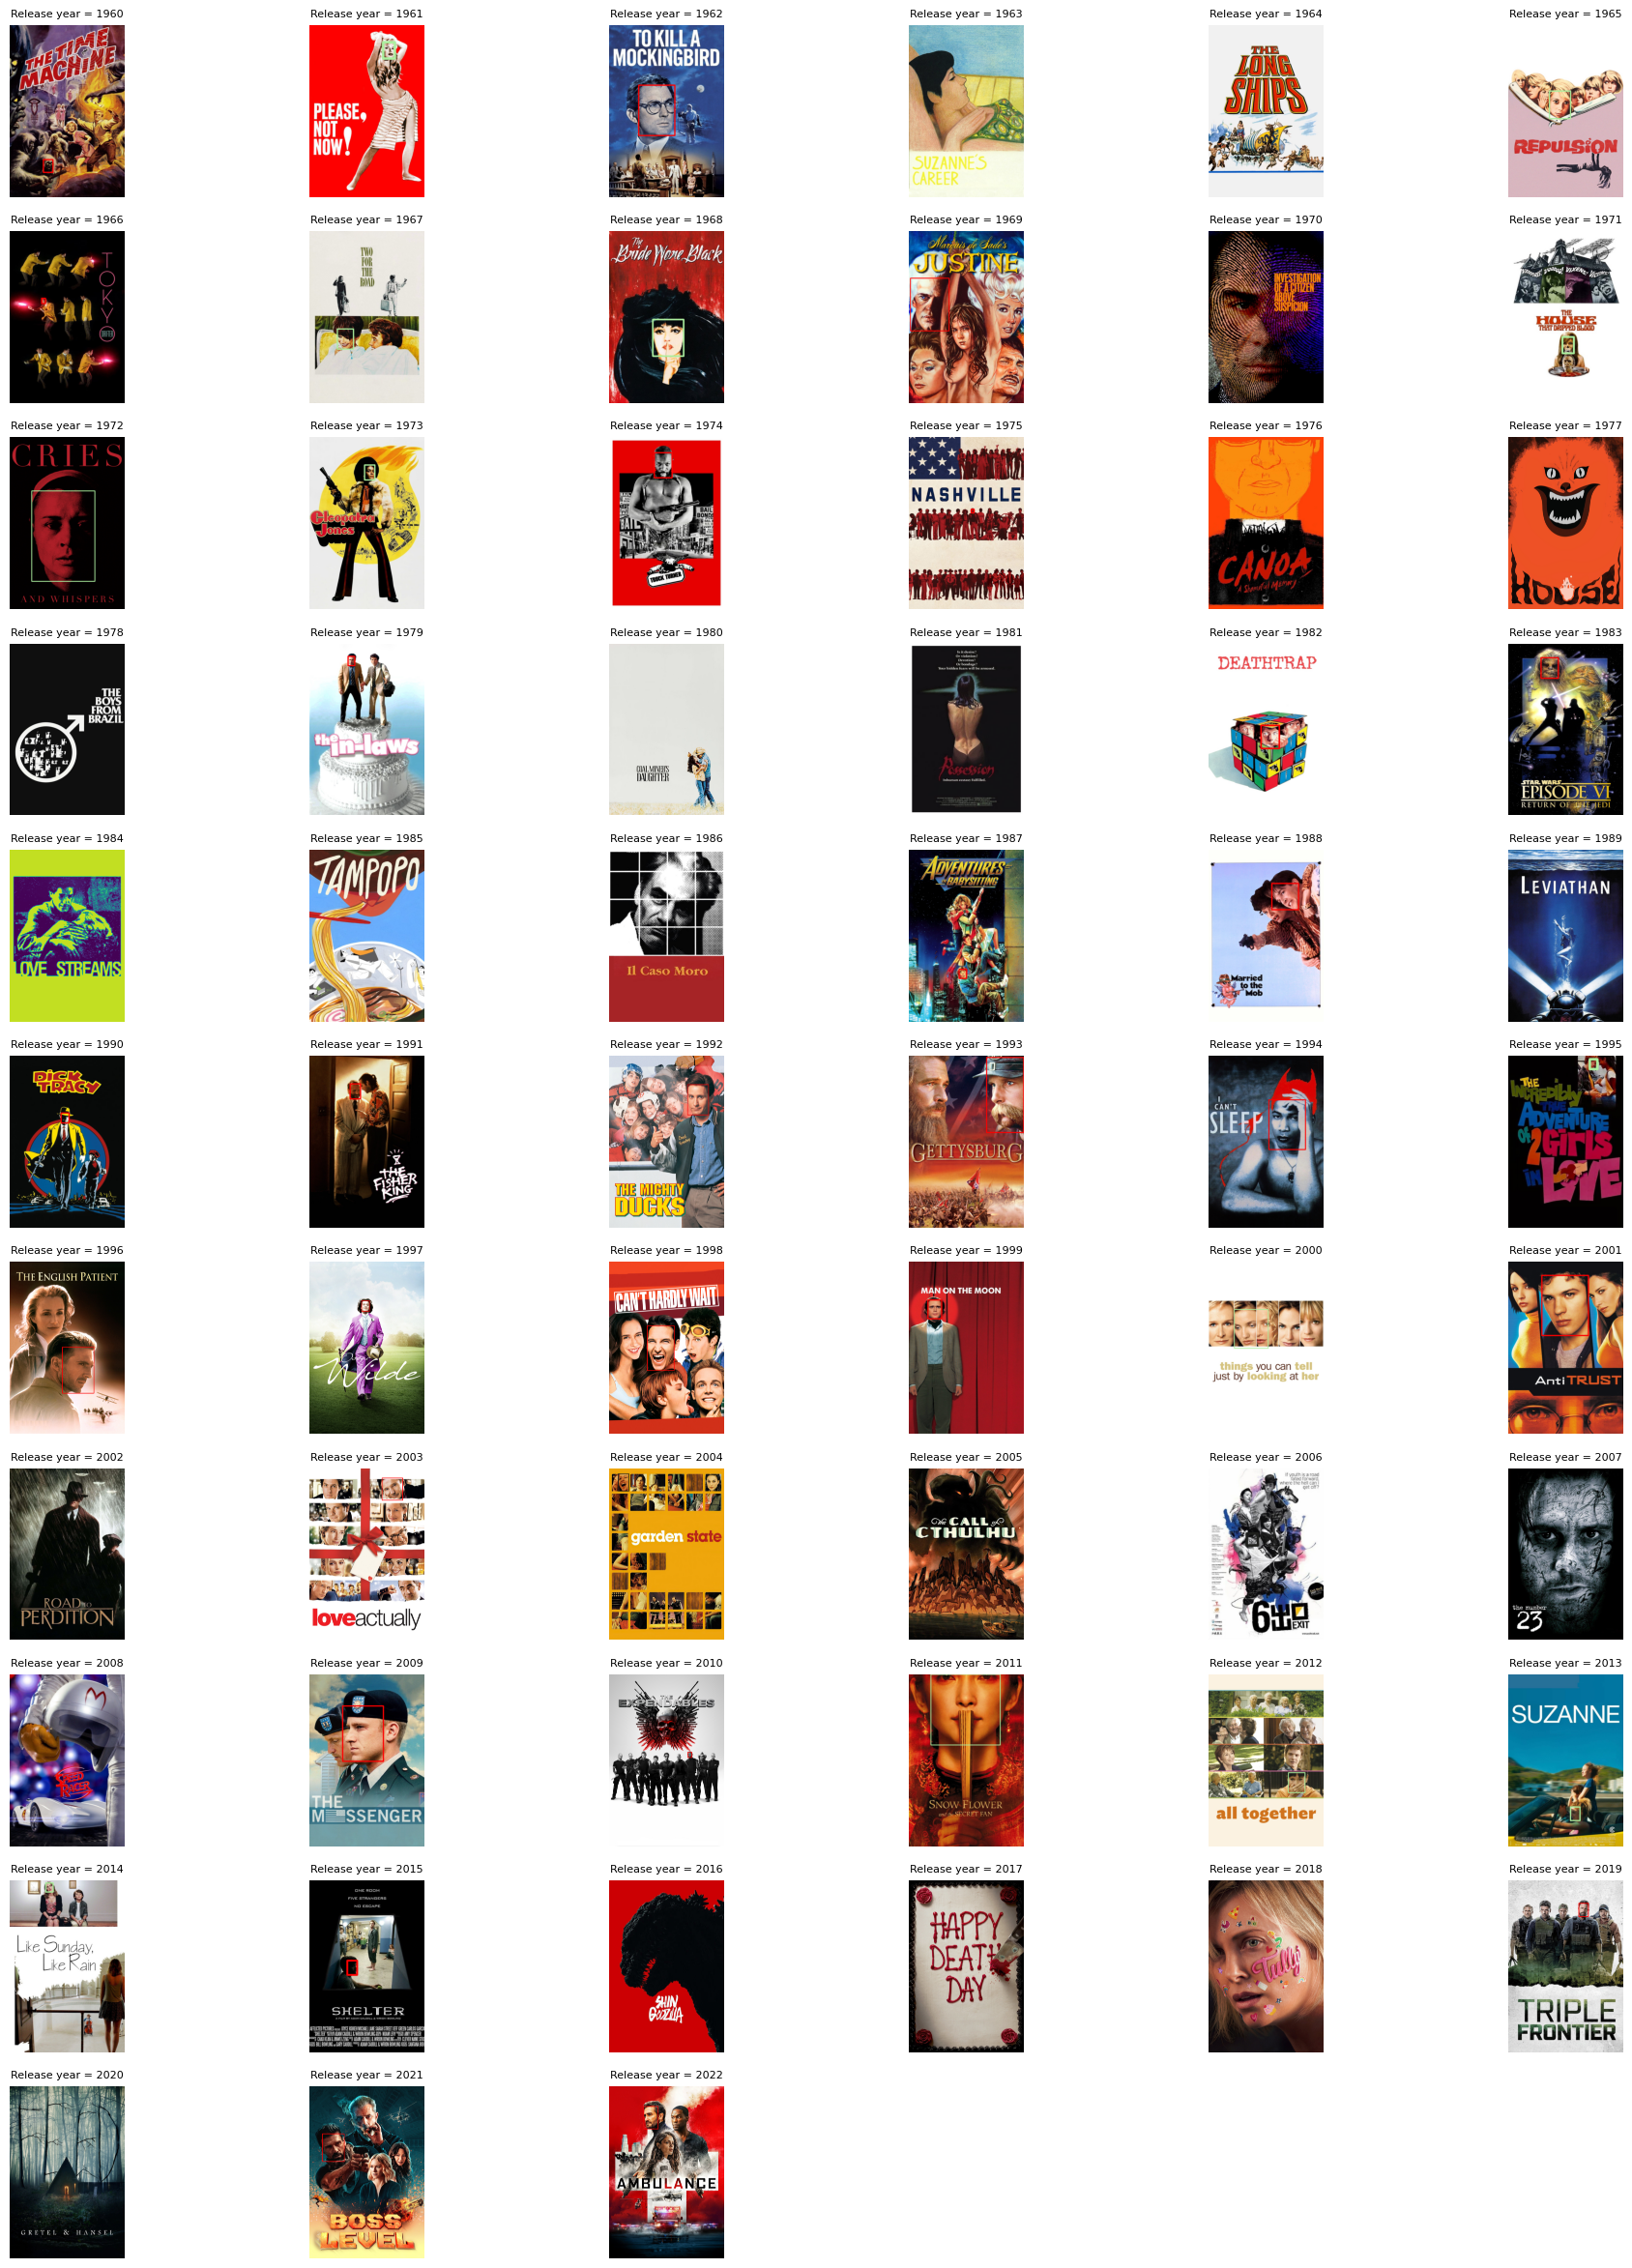

In [53]:
data = (metadata_select2.sort_values("release_year", ascending = True)
        .groupby("release_year")
        .sample(n = 1, random_state = seed)
       )

show_posters_with_main_face(data,
                            poster_folder = poster_folder2,
                            figsize = [24, 30], n_cols = 6, wspace = 0, hspace = 0.2,
                            title = 'year'
                           )

### Analysis over years

In [54]:
data = metadata_select2.groupby(["release_year", "gender"])["id"].count().reset_index()
data[data['release_year']==1970]

release_year   gender  id
27        1970.0  no face   2
28        1970.0  unknown   1
29        1970.0    woman   1

Warning: there is a problem with the second plot for release year = 1970

In [55]:
data = metadata_select2.groupby(["release_year", "gender"])["id"].count().reset_index()

# Plot
column_labels = {"id": "Number of movies (in %)",
                  "gender": "Gender",
                  "release_year": "Release year"
                 }

px.area(data,
        x = "release_year",
        y = "id",
        color = "gender",
        category_orders = {"gender": ['man', 'woman', 'unknown', 'no face']},
        color_discrete_sequence = px.colors.qualitative.Pastel,
        height = 400,
        groupnorm = "percent",
        labels = column_labels
).show()


# Plot
column_labels = {"id": "Number of movies",
                  "gender": "Gender",
                  "release_year": "Release year"
                 }

px.line(data,
        x = "release_year",
        y = "id",
        color = "gender",
        category_orders = {"gender": ['man', 'woman', 'unknown', 'no face']},
        color_discrete_sequence = px.colors.qualitative.Pastel,
        height = 400,
        labels = column_labels
).show()

In [56]:
metadata_select2

id           original_title  release_year  bechdel_rating       man  \
2627  874355        Gone in the Night        2022.0               2  0.091466   
2585  865559  Your Christmas Or Mine?        2022.0               3  0.994484   
2590  848791             The Stranger        2022.0               3  0.900728   
2534  821792                     Bull        2021.0               1  0.985348   
2568  793723               Sentinelle        2021.0               3  0.599223   
...      ...                      ...           ...             ...       ...   
326       85  Raiders of the Lost Ark        1981.0               3  0.976219   
1042      83               Open Water        2003.0               1  0.544705   
1100      74        War of the Worlds        2005.0               3  0.984109   
1133      25                  Jarhead        2005.0               0       NaN   
1004      24        Kill Bill: Vol. 1        2003.0               3  0.073183   

         woman      diff   gender    area  area_percentage_relative  \
2627  0.908534  0.817068    woman  510112                  1.000000   
2585  0.005515  0.988969      man  217159                  0.555343   
2590  0.099272  0.801456      man  592650                  1.000000   
2534  0.014652  0.970696      man  201630                  1.000000   
2568  0.400777  0.198446    woman  999693                  1.000000   
...        ...       ...      ...     ...                       ...   
326   0.023781  0.952439      man  141960                  0.297244   
1042  0.455295  0.089411  unknown   10450                  0.500815   
1100  0.015891  0.968218      man  496107                  0.681756   
1133       NaN       NaN  no face     NaN                       NaN   
1004  0.926817  0.853635    woman   93532                  1.000000   

                                                   rois  
2627  {'face_1': {'score': 0.9977015852928162, 'faci...  
2585  {'face_1': {'score': 0.9997475743293762, 'faci...  
2590  {'face_1': {'score': 0.9992597699165344, 'faci...  
2534  {'face_1': {'score': 0.9996042847633362, 'faci...  
2568  {'face_1': {'score': 0.9993876218795776, 'faci...  
...                                                 ...  
326   {'face_1': {'score': 0.9989423155784607, 'faci...  
1042  {'face_2': {'score': 0.9922425746917725, 'faci...  
1100  {'face_1': {'score': 0.9989603757858276, 'faci...  
1133                                                NaN  
1004  {'face_1': {'score': 0.9991810917854309, 'faci...  

[924 rows x 11 columns]